<a href="https://colab.research.google.com/github/BakhturinaPolina/goodreads-romance-research/blob/main/scraping_ratings_information_expanded_romantic_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cell 1: Install Dependencies and Imports

In [15]:
# Cell 1: Install dependencies and import libraries (Updated with anti-detection for Selenium)
# This cell installs all required packages and sets up Selenium with anti-detection measures

# Install required packages (run this once per Colab session)
!pip install beautifulsoup4 requests pandas selenium tqdm

# For Selenium in Colab: Install Chrome and ChromeDriver
!apt-get update -qq  # Quiet update to avoid verbose output
!apt install -y -qq chromium-chromedriver  # Quiet install

# Ensure chromedriver is in /usr/bin (Colab often has it here already)
import os
chromedriver_path = '/usr/lib/chromium-browser/chromedriver'
if os.path.exists(chromedriver_path) and not os.path.exists('/usr/bin/chromedriver'):
    !cp {chromedriver_path} /usr/bin
    print("Debug: Copied chromedriver to /usr/bin")
else:
    print("Debug: chromedriver already exists in /usr/bin or source path not found")

# Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
import re
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, WebDriverException, NoSuchElementException
from tqdm import tqdm  # For progress bars
import json  # For handling JSON-like data
import os  # For file operations
import sys  # For system paths
from datetime import datetime  # For timestamps in debugging

# Set up Selenium Chrome options for Colab (headless, no sandbox) with anti-detection
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')  # Run without visible browser window
chrome_options.add_argument('--no-sandbox')  # Required for Colab
chrome_options.add_argument('--disable-dev-shm-usage')  # Avoid shared memory issues
chrome_options.add_argument('--disable-gpu')  # Extra stability for headless mode
chrome_options.add_argument('window-size=1920x1080')  # Set a reasonable window size
chrome_options.binary_location = '/usr/bin/chromium-browser'  # Point to the installed Chromium

# Anti-detection options (to avoid bot blocks and empty pages)
chrome_options.add_argument('--disable-blink-features=AutomationControlled')  # Hide Selenium flag
chrome_options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36')
chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
chrome_options.add_experimental_option('useAutomationExtension', False)

# Additional anti-detection measures
chrome_options.add_argument('--disable-web-security')
chrome_options.add_argument('--disable-features=VizDisplayCompositor')
chrome_options.add_argument('--disable-extensions')
chrome_options.add_argument('--disable-default-apps')

# Debug: Print system paths for troubleshooting
print(f"Debug: Python version: {sys.version}")
print(f"Debug: Current time: {datetime.now()}")
print(f"Debug: Chromedriver expected path: /usr/bin/chromedriver")
print(f"Debug: Chromium binary: {chrome_options.binary_location}")

# Initialize the WebDriver with try-except for error handling
try:
    driver = webdriver.Chrome(options=chrome_options)
    print("Debug: WebDriver initialized successfully")

    # Execute CDP commands to hide webdriver
    driver.execute_cdp_cmd('Page.addScriptToEvaluateOnNewDocument', {
        'source': '''
            Object.defineProperty(navigator, 'webdriver', {
                get: () => undefined
            })
        '''
    })
    print("Debug: Added anti-detection CDP commands")

except WebDriverException as e:
    print(f"Error: Failed to initialize WebDriver: {e}")
    raise

# Test WebDriver with Goodreads
try:
    print("\nDebug: Testing WebDriver with Goodreads...")
    driver.get('https://www.goodreads.com/')
    time.sleep(3)
    print(f"Debug: Page title: {driver.title}")
    print(f"Debug: Current URL: {driver.current_url}")

    # Check if page loaded properly
    if driver.page_source and len(driver.page_source) > 1000:
        print(f"Debug: Page loaded successfully (source length: {len(driver.page_source)} chars)")
    else:
        print("Warning: Page source seems empty or too short")

    print("Debug: All dependencies installed and WebDriver ready!")

except Exception as e:
    print(f"Error: Test page load failed: {e}")
    print(f"Debug: Page source sample: {driver.page_source[:500] if driver.page_source else 'No source'}")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
chromium-chromedriver is already the newest version (1:85.0.4183.83-0ubuntu2.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 36 not upgraded.
Debug: chromedriver already exists in /usr/bin or source path not found
Debug: Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Debug: Current time: 2025-08-05 20:59:18.301593
Debug: Chromedriver expected path: /usr/bin/chromedriver
Debug: Chromium binary: /usr/bin/chromium-browser
Debug: WebDriver initialized successfully
Debug: Added anti-detection CDP commands

Debug: Testing WebDriver with Goodreads...
Debug: Page title: Goodreads | Meet your next favorite book
Debug: Current URL: https://www.goodreads.com/
Debug: Page loaded successfully (source length: 62125 chars)
Debug: All dependencies installed and WebDriver ready!


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Cell 2: Define Subgenres and Global Variables

In [16]:
# Cell 2: Define subgenres, URLs, and global configurations
# Fixed: Updated problematic genre URLs to use paginated shelf pages

# List of subgenres and their shelf/genre URLs (FIXED for Romantic Fantasy and Science Fiction Romance)
subgenres = {
    "Contemporary Romance": "https://www.goodreads.com/shelf/show/contemporary-romance",
    "Historical Romance": "https://www.goodreads.com/shelf/show/historical-romance",
    "Paranormal Romance": "https://www.goodreads.com/shelf/show/paranormal-romance",
    "Romantic Suspense": "https://www.goodreads.com/shelf/show/romantic-suspense",
    "Romantic Fantasy": "https://www.goodreads.com/shelf/show/fantasy-romance",  # FIXED: Changed from /genres/ to /shelf/show/
    "Science Fiction Romance": "https://www.goodreads.com/shelf/show/science-fiction-romance"  # FIXED: Changed to shelf URL
}

# Alternative URLs in case the above don't work
alternative_urls = {
    "Romantic Fantasy": "https://www.goodreads.com/shelf/show/romance-fantasy",
    "Science Fiction Romance": "https://www.goodreads.com/shelf/show/sci-fi-romance"
}

# Configurable scraping limits
MIN_BOOKS_PER_SUBGENRE = 200  # Minimum to collect
MAX_BOOKS_PER_SUBGENRE = 300  # Maximum to aim for
MAX_PAGES_PER_SUBGENRE = 15  # Safety cap on pagination (15 pages * 30 books/page = ~450 books)
MAX_REVIEWS_PER_BOOK = 200  # Cap for reviews
ALL_REVIEWS = False  # Set to True to scrape ALL reviews
DELAY_MIN = 3  # Minimum delay between requests (seconds) - Increased for safety
DELAY_MAX = 7  # Maximum delay - Increased for safety
MAX_RETRIES = 3  # Max retries for page loads

# User-agents to rotate (helps avoid detection)
USER_AGENTS = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:91.0) Gecko/20100101 Firefox/91.0',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
]

# Headers for requests
HEADERS = {
    'User-Agent': random.choice(USER_AGENTS),
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Language': 'en-US,en;q=0.5',
    'Accept-Encoding': 'gzip, deflate, br',
    'DNT': '1',
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1'
}

# Empty list to store all scraped book data
all_books = []

# Debug prints
print("Debug: Subgenres defined:")
for genre, url in subgenres.items():
    print(f"  - {genre}: {url}")
print(f"\nDebug: Configuration:")
print(f"  - Books per subgenre: {MIN_BOOKS_PER_SUBGENRE} to {MAX_BOOKS_PER_SUBGENRE}")
print(f"  - Max pages per subgenre: {MAX_PAGES_PER_SUBGENRE}")
print(f"  - Max reviews per book: {MAX_REVIEWS_PER_BOOK} (all_reviews={ALL_REVIEWS})")
print(f"  - Delays between requests: {DELAY_MIN}-{DELAY_MAX} seconds")
print(f"  - Max retries per page: {MAX_RETRIES}")
print(f"  - User agents available: {len(USER_AGENTS)}")
print("\nDebug: Configuration complete. Ready to define scraping functions.")

Debug: Subgenres defined:
  - Contemporary Romance: https://www.goodreads.com/shelf/show/contemporary-romance
  - Historical Romance: https://www.goodreads.com/shelf/show/historical-romance
  - Paranormal Romance: https://www.goodreads.com/shelf/show/paranormal-romance
  - Romantic Suspense: https://www.goodreads.com/shelf/show/romantic-suspense
  - Romantic Fantasy: https://www.goodreads.com/shelf/show/fantasy-romance
  - Science Fiction Romance: https://www.goodreads.com/shelf/show/science-fiction-romance

Debug: Configuration:
  - Books per subgenre: 200 to 300
  - Max pages per subgenre: 15
  - Max reviews per book: 200 (all_reviews=False)
  - Delays between requests: 3-7 seconds
  - Max retries per page: 3
  - User agents available: 4

Debug: Configuration complete. Ready to define scraping functions.


In [17]:
# Cell 2: Define subgenres, URLs, and global configurations
# Updated: Increased book targets to 500 per subgenre to account for duplicates and missing EPUBs

# List of subgenres and their shelf/genre URLs
subgenres = {
    "Contemporary Romance": "https://www.goodreads.com/shelf/show/contemporary-romance",
    "Historical Romance": "https://www.goodreads.com/shelf/show/historical-romance",
    "Paranormal Romance": "https://www.goodreads.com/shelf/show/paranormal-romance",
    "Romantic Suspense": "https://www.goodreads.com/shelf/show/romantic-suspense",
    "Romantic Fantasy": "https://www.goodreads.com/shelf/show/fantasy-romance",
    "Science Fiction Romance": "https://www.goodreads.com/shelf/show/science-fiction-romance"
}

# Alternative URLs in case the above don't work
alternative_urls = {
    "Romantic Fantasy": "https://www.goodreads.com/shelf/show/romance-fantasy",
    "Science Fiction Romance": "https://www.goodreads.com/shelf/show/sci-fi-romance"
}

# Updated scraping limits for 500 books per subgenre
MIN_BOOKS_PER_SUBGENRE = 450  # Minimum to collect (allowing for some failures)
MAX_BOOKS_PER_SUBGENRE = 500  # Target for each subgenre
MAX_PAGES_PER_SUBGENRE = 20  # Increased from 15 (20 pages * 30 books/page = ~600 books)
MAX_REVIEWS_PER_BOOK = 200  # Cap for reviews
ALL_REVIEWS = False  # Set to True to scrape ALL reviews
DELAY_MIN = 3  # Minimum delay between requests (seconds)
DELAY_MAX = 7  # Maximum delay
MAX_RETRIES = 3  # Max retries for page loads

# Author diversity settings
MAX_BOOKS_PER_AUTHOR = 5  # Limit to increase diversity
APPLY_AUTHOR_LIMIT = False  # Set to True to enforce during scraping (or apply post-scraping)

# User-agents to rotate
USER_AGENTS = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:91.0) Gecko/20100101 Firefox/91.0',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
]

# Headers for requests
HEADERS = {
    'User-Agent': random.choice(USER_AGENTS),
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Language': 'en-US,en;q=0.5',
    'Accept-Encoding': 'gzip, deflate, br',
    'DNT': '1',
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1'
}

# Empty list to store all scraped book data
all_books = []

# Debug prints
print("Debug: Updated configuration for 500 books per subgenre")
print(f"  - Target books per subgenre: {MAX_BOOKS_PER_SUBGENRE}")
print(f"  - Max pages to scrape: {MAX_PAGES_PER_SUBGENRE}")
print(f"  - Author limit: {MAX_BOOKS_PER_AUTHOR} books per author (enabled: {APPLY_AUTHOR_LIMIT})")
print(f"  - Total expected books: ~{len(subgenres) * MAX_BOOKS_PER_SUBGENRE} (before deduplication)")

Debug: Updated configuration for 500 books per subgenre
  - Target books per subgenre: 500
  - Max pages to scrape: 20
  - Author limit: 5 books per author (enabled: False)
  - Total expected books: ~3000 (before deduplication)


# Cell 3: Cookie Management Function

In [18]:
# Cell 3: Cookie management function with environment variables and complete cookies
# This cell handles cookie loading and login verification

import os
from datetime import datetime, timedelta

def load_cookies(driver, auto_login=False):
    """
    Load cookies to simulate logged-in state or perform auto-login.
    Args:
        driver: Selenium WebDriver instance
        auto_login: If True, attempt automated login if cookies fail
    Returns:
        bool: True if login successful, False otherwise
    """
    print("\n" + "="*50)
    print("Debug: Starting cookie/login process...")
    print("="*50)

    # Complete cookie list from your provided data
    cookies = [
        {
            'name': '_session_id2',
            'value': '6c4ac9d7944645498873dcfaf76b294f',
            'domain': 'www.goodreads.com',
            'path': '/',
            'secure': True,
            'expiry': int((datetime.now() + timedelta(days=365)).timestamp())  # 1 year from now
        },
        {
            'name': 'at-main',
            'value': 'Atza|IwEBIP_WVjU2wDt5XXIwnYO37c_HBxHHpvejaw457NkT7-DHU7flVrkMM02XEH0cYeYRpEYlSuc7aN4cr-0ME-ruM28LUkrC7ODW8WKTpaqeH-sCuNVv1z9YM7xBS-Z4T0jhtLlPe8xzqTMozRae_ZNoxsqvpLNQxyDu0Woeei-Ip3E_PYxuZeikLbIDzpe17BVcrNocfqj4fl5KszGyF7ExHAvfVTGVBH_UeX5rQbSY6ZOCTHiIoca2U5sZfChiCoUH3wk',
            'domain': '.goodreads.com',
            'path': '/',
            'secure': True,
            'httpOnly': True,
            'expiry': int((datetime.now() + timedelta(days=365*2)).timestamp())
        },
        {
            'name': 'ccsid',
            'value': '724-3321647-0772806',
            'domain': 'www.goodreads.com',
            'path': '/',
            'secure': False,
            'expiry': int((datetime.now() + timedelta(days=365*2)).timestamp())
        },
        {
            'name': 'csm-hit',
            'value': 'tb:s-2R1WY81WFQ4QG5VKQVVG|1754352395507&t:1754352395508',
            'domain': 'www.goodreads.com',
            'path': '/',
            'secure': False,
            'expiry': int((datetime.now() + timedelta(days=365)).timestamp())
        },
        {
            'name': 'lc-main',
            'value': 'en_US',
            'domain': '.goodreads.com',
            'path': '/',
            'secure': False,
            'httpOnly': True,
            'expiry': int((datetime.now() + timedelta(days=365*2)).timestamp())
        },
        {
            'name': 'locale',
            'value': 'en',
            'domain': 'www.goodreads.com',
            'path': '/',
            'secure': False
            # Session cookie, no expiry
        },
        {
            'name': 'logged_out_browsing_page_count',
            'value': '1',
            'domain': 'www.goodreads.com',
            'path': '/',
            'secure': False,
            'expiry': int((datetime.now() + timedelta(days=365*2)).timestamp())
        },
        {
            'name': 'sess-at-main',
            'value': 'U8NDSc1MTsE8derMKmAGMZ+Uq9chMayYrfiC+B46wCE=',
            'domain': '.goodreads.com',
            'path': '/',
            'secure': True,
            'httpOnly': True,
            'expiry': int((datetime.now() + timedelta(days=365*2)).timestamp())
        },
        {
            'name': 'session-id',
            'value': '140-3588248-4268607',
            'domain': '.goodreads.com',
            'path': '/',
            'secure': False,
            'httpOnly': True,
            'expiry': int((datetime.now() + timedelta(days=365*2)).timestamp())
        },
        {
            'name': 'session-id-time',
            'value': '2385072442l',
            'domain': '.goodreads.com',
            'path': '/',
            'secure': False,
            'httpOnly': True,
            'expiry': int((datetime.now() + timedelta(days=365*2)).timestamp())
        },
        {
            'name': 'session-token',
            'value': '0+8P54n7E6d+0GGShiBALFOEgtTQdUdna1ExcAeRw3Ul16HkHsMc2W2ZpSYd+dn2CmsRT4KTntQt8WF4Of+YP1EitZ4QW4VQMG/hg3NoH61WK00ztRFxR6GkLoQiygwTiqkHExpG3pEjipb2/x256UoQDqyJcqAdFLyXukWtVKwfCFNsWzxJZMP/gmSX/Ml1mSdPMmkb9yJ5gb+ugF6z5a1F2Hr01Tt1Ynz77AY8fV5BunhvuaXJYoMJjEKHvWoLmurVyyWT/YZ71mOlJJXAtphVwQmemG3C27hNxcCL3cC3x1N6iA36seE5LzPJmOkxNjbGZ5EnO3s+IVXsenDzWijTZZz3dAu9eDn03BYbLEF0fsf7cW4b3g==',
            'domain': '.goodreads.com',
            'path': '/',
            'secure': False,
            'httpOnly': True,
            'expiry': int((datetime.now() + timedelta(days=365*2)).timestamp())
        },
        {
            'name': 'ubid-main',
            'value': '135-7477912-2392604',
            'domain': '.goodreads.com',
            'path': '/',
            'secure': False,
            'httpOnly': True,
            'expiry': int((datetime.now() + timedelta(days=365*2)).timestamp())
        },
        {
            'name': 'x-main',
            'value': 'hf5q7qpx3x0HgBwzCGe?XOExwXUrkUVkjz1Z15Z2ptg0JUWQ9klSPvPcAXY9G41Z',
            'domain': '.goodreads.com',
            'path': '/',
            'secure': False,
            'httpOnly': True,
            'expiry': int((datetime.now() + timedelta(days=365*2)).timestamp())
        }
    ]

    try:
        # First, navigate to Goodreads to set domain
        print("Debug: Navigating to Goodreads homepage...")
        driver.get('https://www.goodreads.com/')
        time.sleep(2)

        # Clear existing cookies
        driver.delete_all_cookies()
        print("Debug: Cleared all existing cookies")

        # Add cookies
        print(f"Debug: Adding {len(cookies)} cookies...")
        successfully_added = 0
        for i, cookie in enumerate(cookies):
            try:
                # Remove 'expiry' key if it's a session cookie
                if 'expiry' not in cookie or cookie.get('name') == 'locale':
                    cookie_to_add = {k: v for k, v in cookie.items() if k != 'expiry'}
                else:
                    cookie_to_add = cookie.copy()

                driver.add_cookie(cookie_to_add)
                successfully_added += 1
                if i < 5 or i % 5 == 0:  # Log first 5 and then every 5th
                    print(f"Debug: Added cookie {i+1}/{len(cookies)}: {cookie['name']}")
            except Exception as e:
                print(f"Warning: Failed to add cookie '{cookie['name']}': {e}")

        print(f"Debug: Successfully added {successfully_added}/{len(cookies)} cookies")

        # Refresh to apply cookies
        print("Debug: Refreshing page to apply cookies...")
        driver.refresh()
        time.sleep(3)

        # Verify login by checking for profile elements
        print("Debug: Verifying login status...")
        logged_in = False

        # Check multiple indicators of being logged in
        login_indicators = [
            (By.CLASS_NAME, 'siteHeader__personalMenu'),
            (By.CLASS_NAME, 'profileMenu'),
            (By.XPATH, "//span[@class='headerPersonalNav__icon']"),
            (By.XPATH, "//a[@href='/review/list']"),  # "My Books" link
            (By.XPATH, "//a[contains(@href, '/user/show/')]"),  # Profile link
            (By.CLASS_NAME, 'dropdown__trigger--profileMenu')  # Profile dropdown
        ]

        for by, value in login_indicators:
            try:
                element = driver.find_element(by, value)
                if element:
                    print(f"Debug: Found login indicator: {value}")
                    logged_in = True
                    break
            except NoSuchElementException:
                continue

        if logged_in:
            print("Success: Cookie-based login successful!")
            print(f"Debug: Current page title: {driver.title}")
            return True
        else:
            print("Warning: No login indicators found. Cookies may be expired.")
            print(f"Debug: Page title: {driver.title}")
            print(f"Debug: Current URL: {driver.current_url}")

            # Check if we see any sign-in prompts
            try:
                sign_in_element = driver.find_element(By.XPATH, "//a[contains(text(), 'Sign In')]")
                if sign_in_element:
                    print("Debug: Found 'Sign In' link - definitely not logged in")
            except NoSuchElementException:
                print("Debug: No 'Sign In' link found")

            # Optional: Try automated login
            if auto_login:
                print("\nDebug: Attempting automated login...")
                return attempt_auto_login(driver)

            return False

    except Exception as e:
        print(f"Error in load_cookies: {e}")
        import traceback
        traceback.print_exc()
        return False

def attempt_auto_login(driver):
    """
    Attempt automated login using environment variables
    Set these environment variables before running:
    - GOODREADS_EMAIL: Your Goodreads email
    - GOODREADS_PASSWORD: Your Goodreads password
    """
    try:
        # Get credentials from environment variables
        email = os.environ.get('GOODREADS_EMAIL')
        password = os.environ.get('GOODREADS_PASSWORD')

        if not email or not password:
            print("ERROR: Environment variables GOODREADS_EMAIL and GOODREADS_PASSWORD not set!")
            print("\nTo set them in Colab, run these commands in a cell:")
            print("import os")
            print("os.environ['GOODREADS_EMAIL'] = 'your_email@example.com'")
            print("os.environ['GOODREADS_PASSWORD'] = 'your_password'")
            print("\nOr set them in your system before running the notebook.")
            return False

        print("Debug: Environment variables found. Attempting login...")
        print(f"Debug: Using email: {email[:3]}...{email[-10:]}")  # Partially masked for security

        # Navigate to login page
        print("Debug: Navigating to login page...")
        driver.get('https://www.goodreads.com/user/sign_in')
        time.sleep(3)

        # Check for login form
        try:
            # Wait for form elements
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.ID, 'user_email'))
            )

            email_field = driver.find_element(By.ID, 'user_email')
            password_field = driver.find_element(By.ID, 'user_password')

            print("Debug: Login form found. Filling credentials...")

            # Clear and fill fields
            email_field.clear()
            email_field.send_keys(email)

            password_field.clear()
            password_field.send_keys(password)

            # Find and click sign in button
            sign_in_button = driver.find_element(By.NAME, 'commit')
            print("Debug: Clicking sign in button...")
            sign_in_button.click()

            # Wait for login to process
            time.sleep(5)

            # Check if login successful
            if "sign_in" not in driver.current_url.lower():
                print("Success: Automated login successful!")
                print(f"Debug: Redirected to: {driver.current_url}")
                return True
            else:
                print("Error: Login failed. Possible reasons:")
                print("  - Invalid credentials")
                print("  - CAPTCHA required")
                print("  - Account locked")

                # Check for error messages
                try:
                    error_elem = driver.find_element(By.CLASS_NAME, 'flash_error')
                    print(f"  - Error message: {error_elem.text}")
                except NoSuchElementException:
                    pass

                return False

        except TimeoutException:
            print("Error: Login form not found. Page may have changed.")
            print(f"Debug: Current URL: {driver.current_url}")
            return False
        except NoSuchElementException as e:
            print(f"Error: Could not find login form element: {e}")
            return False

    except Exception as e:
        print(f"Error in automated login: {e}")
        import traceback
        traceback.print_exc()
        return False

# Instructions for setting environment variables in Colab
print("="*70)
print("IMPORTANT: Setting up credentials")
print("="*70)
print("\nTo use automated login, set environment variables:")
print("\nOption 1 - In a code cell (temporary):")
print("```python")
print("import os")
print("os.environ['GOODREADS_EMAIL'] = 'your_email@example.com'")
print("os.environ['GOODREADS_PASSWORD'] = 'your_password'")
print("```")
print("\nOption 2 - Using Colab secrets (permanent for notebook):")
print("1. Click the key icon 🔑 in the left sidebar")
print("2. Add new secrets: GOODREADS_EMAIL and GOODREADS_PASSWORD")
print("3. Access them with:")
print("```python")
print("from google.colab import userdata")
print("os.environ['GOODREADS_EMAIL'] = userdata.get('GOODREADS_EMAIL')")
print("os.environ['GOODREADS_PASSWORD'] = userdata.get('GOODREADS_PASSWORD')")
print("```")
print("\n" + "="*70)

# Test cookie loading
print("\nDebug: Testing cookie loading...")
login_success = load_cookies(driver, auto_login=False)  # Set to True to try auto-login if cookies fail
print(f"Debug: Login test result: {'Success' if login_success else 'Failed'}")

if not login_success:
    print("\nDebug: Cookies may be expired. Consider:")
    print("1. Getting fresh cookies from your browser")
    print("2. Setting environment variables and using auto_login=True")
    print("3. Checking if Goodreads has changed their login system")

IMPORTANT: Setting up credentials

To use automated login, set environment variables:

Option 1 - In a code cell (temporary):
```python
import os
os.environ['GOODREADS_EMAIL'] = 'your_email@example.com'
os.environ['GOODREADS_PASSWORD'] = 'your_password'
```

Option 2 - Using Colab secrets (permanent for notebook):
1. Click the key icon 🔑 in the left sidebar
2. Add new secrets: GOODREADS_EMAIL and GOODREADS_PASSWORD
3. Access them with:
```python
from google.colab import userdata
os.environ['GOODREADS_EMAIL'] = userdata.get('GOODREADS_EMAIL')
os.environ['GOODREADS_PASSWORD'] = userdata.get('GOODREADS_PASSWORD')
```


Debug: Testing cookie loading...

Debug: Starting cookie/login process...
Debug: Navigating to Goodreads homepage...
Debug: Cleared all existing cookies
Debug: Adding 13 cookies...
Debug: Added cookie 1/13: _session_id2
Debug: Added cookie 2/13: at-main
Debug: Added cookie 3/13: ccsid
Debug: Added cookie 4/13: csm-hit
Debug: Added cookie 5/13: lc-main
Debug: Added cookie 6/

# Cell 4: Main Scraping Function

In [19]:
# Cell 4: Main book scraping function with all fixes implemented
# This is the core function that scrapes books from each subgenre

def scrape_subgenre_books(genre, base_url, max_pages=None):
    """
    Scrape book details from a subgenre's paginated list using Selenium.
    Fixed version with improved selectors and error handling.
    """
    print("\n" + "="*70)
    print(f"STARTING SCRAPE: {genre}")
    print(f"URL: {base_url}")
    print(f"Time: {datetime.now()}")
    print("="*70)

    # Use global max pages if not specified
    if max_pages is None:
        max_pages = MAX_PAGES_PER_SUBGENRE

    collected_books = []
    seen_ids = set()
    page = 1
    consecutive_failures = 0
    max_consecutive_failures = 3

    try:
        # Load cookies first (if not already loaded)
        if page == 1:
            print("Debug: Ensuring logged-in state...")
            load_cookies(driver, auto_login=False)

        # Navigate to the subgenre page
        print(f"\nDebug: Loading initial page: {base_url}")
        driver.get(base_url)
        time.sleep(random.uniform(3, 5))

        # Check if page loaded properly
        if "Page not found" in driver.title or "404" in driver.title:
            print(f"ERROR: 404 - Page not found for {genre}")
            print(f"Debug: Trying alternative URL if available...")
            if genre in alternative_urls:
                base_url = alternative_urls[genre]
                print(f"Debug: Using alternative URL: {base_url}")
                driver.get(base_url)
                time.sleep(random.uniform(3, 5))
            else:
                return collected_books

        print(f"Debug: Initial page loaded. Title: {driver.title}")
        print(f"Debug: Current URL: {driver.current_url}")

        # Main pagination loop
        while len(collected_books) < MAX_BOOKS_PER_SUBGENRE and page <= max_pages:
            print(f"\n--- Page {page} ---")
            retry_count = 0
            page_success = False

            while retry_count < MAX_RETRIES and not page_success:
                try:
                    # Wait for book elements to load
                    print(f"Debug: Waiting for book elements (attempt {retry_count + 1})...")

                    # Try multiple possible selectors
                    book_selectors = [
                        (By.CLASS_NAME, 'elementList'),
                        (By.CLASS_NAME, 'tableList'),
                        (By.CSS_SELECTOR, 'tr.bookalike'),
                        (By.CSS_SELECTOR, 'div.leftContainer div.elementList')
                    ]

                    books_found = False
                    for by, selector in book_selectors:
                        try:
                            WebDriverWait(driver, 10).until(
                                EC.presence_of_element_located((by, selector))
                            )
                            print(f"Debug: Found books using selector: {selector}")
                            books_found = True
                            break
                        except TimeoutException:
                            continue

                    if not books_found:
                        raise TimeoutException("No book elements found with any selector")

                    page_success = True
                    print(f"Debug: Page {page} loaded successfully")

                except TimeoutException:
                    retry_count += 1
                    print(f"Debug: Timeout on page {page}, attempt {retry_count}")

                    if retry_count < MAX_RETRIES:
                        print("Debug: Refreshing page...")
                        driver.refresh()
                        time.sleep(5)
                    else:
                        print("ERROR: Max retries exceeded")
                        print(f"Debug: Page source preview: {driver.page_source[:1000]}")
                        consecutive_failures += 1
                        break

            if not page_success:
                if consecutive_failures >= max_consecutive_failures:
                    print(f"ERROR: {consecutive_failures} consecutive page failures. Stopping.")
                    break
                continue

            # Reset consecutive failures on success
            consecutive_failures = 0

            # Parse page with BeautifulSoup
            soup = BeautifulSoup(driver.page_source, 'html.parser')

            # Find all book items (try multiple selectors)
            book_items = []

            # Primary selector for shelf pages
            book_items.extend(soup.find_all('div', class_='elementList'))

            # Also try table rows (some pages use tables)
            book_items.extend(soup.find_all('tr', class_='bookalike'))

            # Remove None values
            book_items = [item for item in book_items if item]

            print(f"Debug: Found {len(book_items)} potential book items")

            if not book_items:
                print("Warning: No book items found on this page")
                consecutive_failures += 1
                if consecutive_failures >= max_consecutive_failures:
                    print("ERROR: No books found on multiple pages. Stopping.")
                    break

            # Extract book details
            books_added_this_page = 0
            for i, item in enumerate(book_items):
                try:
                    # Extract title
                    title_elem = item.find('a', class_='bookTitle')
                    if not title_elem:
                        # Try alternative selector
                        title_elem = item.find('a', class_='gr-h3__noDecoration--pageTitle')

                    title = title_elem.text.strip() if title_elem else None

                    # Extract author
                    author_elem = item.find('a', class_='authorName')
                    if not author_elem:
                        # Try alternative selectors
                        author_elem = item.find('span', itemprop='name')

                    author = author_elem.text.strip() if author_elem else None

                    # Extract URL and book ID
                    if title_elem and title_elem.get('href'):
                        url_partial = title_elem['href']
                        full_url = f"https://www.goodreads.com{url_partial.split('?')[0]}"

                        # Extract book ID from URL
                        book_id_match = re.search(r'/show/(\d+)', url_partial)
                        if not book_id_match:
                            book_id_match = re.search(r'/book/show/(\d+)', url_partial)

                        book_id = book_id_match.group(1) if book_id_match else None
                    else:
                        full_url = None
                        book_id = None

                    # Validate and add book
                    if book_id and title and author and book_id not in seen_ids:
                        seen_ids.add(book_id)
                        book_data = {
                            'book_id': book_id,
                            'title': title,
                            'author': author,
                            'url': full_url,
                            'subgenre': genre,
                            'page_scraped': page,
                            'timestamp': datetime.now().isoformat()
                        }
                        collected_books.append(book_data)
                        books_added_this_page += 1

                        if len(collected_books) % 10 == 0:  # Log every 10th book
                            print(f"Debug: Collected {len(collected_books)} books so far")

                        # Stop if we've reached the maximum
                        if len(collected_books) >= MAX_BOOKS_PER_SUBGENRE:
                            print(f"Debug: Reached maximum books ({MAX_BOOKS_PER_SUBGENRE})")
                            break

                    elif book_id in seen_ids:
                        print(f"Debug: Skipped duplicate book ID: {book_id}")
                    elif not all([book_id, title, author]):
                        missing = []
                        if not book_id: missing.append("ID")
                        if not title: missing.append("title")
                        if not author: missing.append("author")
                        if i < 3:  # Only log first few to avoid spam
                            print(f"Debug: Skipped book missing: {', '.join(missing)}")

                except Exception as e:
                    print(f"Warning: Error extracting book {i+1}: {e}")
                    continue

            print(f"Debug: Added {books_added_this_page} new books from page {page}")
            print(f"Debug: Total books collected: {len(collected_books)}")

            # If no new books added, might be at the end
            if books_added_this_page == 0:
                print("Warning: No new books added from this page")
                consecutive_failures += 1
                if consecutive_failures >= max_consecutive_failures:
                    print("Debug: No new content. Stopping pagination.")
                    break

            # Check if we should continue to next page
            if len(collected_books) >= MAX_BOOKS_PER_SUBGENRE or page >= max_pages:
                print(f"Debug: Stopping - reached {'max books' if len(collected_books) >= MAX_BOOKS_PER_SUBGENRE else 'max pages'}")
                break

            # Find and click next button
            try:
                print("Debug: Looking for next button...")

                # Multiple strategies for finding next button
                next_button = None

                # Strategy 1: Look for "next" link with class
                try:
                    next_button = driver.find_element(By.XPATH, "//a[@class='next_page' and @rel='next']")
                except NoSuchElementException:
                    pass

                # Strategy 2: Look for any element with "next_page" class
                if not next_button:
                    try:
                        next_button = driver.find_element(By.CLASS_NAME, "next_page")
                    except NoSuchElementException:
                        pass

                # Strategy 3: Look for "Next »" text
                if not next_button:
                    try:
                        next_button = driver.find_element(By.XPATH, "//a[contains(text(),'Next')]")
                    except NoSuchElementException:
                        pass

                if next_button:
                    # Check if button is disabled
                    if 'disabled' in next_button.get_attribute('class'):
                        print("Debug: Next button is disabled. Reached end of results.")
                        break

                    print("Debug: Next button found. Scrolling to it...")
                    driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
                    time.sleep(1)

                    # Try clicking with JavaScript first (more reliable)
                    print("Debug: Clicking next button...")
                    driver.execute_script("arguments[0].click();", next_button)

                    page += 1
                    print(f"Debug: Navigated to page {page}")

                    # Random delay to mimic human behavior
                    delay = random.uniform(DELAY_MIN, DELAY_MAX)
                    print(f"Debug: Waiting {delay:.1f} seconds before next page...")
                    time.sleep(delay)

                else:
                    print("Debug: No next button found. Reached end of pagination.")
                    break

            except Exception as e:
                print(f"Debug: Error with pagination: {e}")
                break

        # Final summary for this subgenre
        print(f"\n{'='*70}")
        print(f"COMPLETED: {genre}")
        print(f"Total pages scraped: {page}")
        print(f"Total unique books collected: {len(collected_books)}")
        print(f"Time: {datetime.now()}")
        print(f"{'='*70}\n")

    except Exception as e:
        print(f"ERROR: Fatal error while scraping {genre}: {e}")
        import traceback
        traceback.print_exc()

    return collected_books

# Test with a single subgenre
print("Debug: Testing with Contemporary Romance...")
test_books = scrape_subgenre_books("Contemporary Romance", subgenres["Contemporary Romance"], max_pages=2)
print(f"\nTest Results: Found {len(test_books)} books")
if test_books:
    print("Sample book:", test_books[0])

Debug: Testing with Contemporary Romance...

STARTING SCRAPE: Contemporary Romance
URL: https://www.goodreads.com/shelf/show/contemporary-romance
Time: 2025-08-05 20:59:30.268974
Debug: Ensuring logged-in state...

Debug: Starting cookie/login process...
Debug: Navigating to Goodreads homepage...
Debug: Cleared all existing cookies
Debug: Adding 13 cookies...
Debug: Added cookie 1/13: _session_id2
Debug: Added cookie 2/13: at-main
Debug: Added cookie 3/13: ccsid
Debug: Added cookie 4/13: csm-hit
Debug: Added cookie 5/13: lc-main
Debug: Added cookie 6/13: locale
Debug: Added cookie 11/13: session-token
Debug: Successfully added 13/13 cookies
Debug: Refreshing page to apply cookies...
Debug: Verifying login status...
Debug: Found login indicator: //span[@class='headerPersonalNav__icon']
Success: Cookie-based login successful!
Debug: Current page title: Recent updates | Goodreads

Debug: Loading initial page: https://www.goodreads.com/shelf/show/contemporary-romance
Debug: Initial page lo

# Cell 5: Scrape All Subgenres

In [20]:
# Cell 5: Main execution - Scrape all subgenres
# This cell orchestrates the scraping of all subgenres

# Reset the books list
all_books = []
scraping_summary = {}

print("="*80)
print("STARTING FULL SCRAPING RUN")
print(f"Target: {len(subgenres)} subgenres")
print(f"Books per subgenre: {MIN_BOOKS_PER_SUBGENRE}-{MAX_BOOKS_PER_SUBGENRE}")
print(f"Start time: {datetime.now()}")
print("="*80)

# Iterate through all subgenres
for idx, (genre, url) in enumerate(subgenres.items(), 1):
    print(f"\n{'#'*80}")
    print(f"SUBGENRE {idx}/{len(subgenres)}: {genre}")
    print(f"{'#'*80}")

    start_time = time.time()

    try:
        # Scrape books for this subgenre
        genre_books = scrape_subgenre_books(genre, url)

        # Store results
        all_books.extend(genre_books)
        scraping_summary[genre] = {
            'books_found': len(genre_books),
            'success': len(genre_books) > 0,
            'time_taken': round(time.time() - start_time, 2)
        }

        print(f"\nSummary for {genre}:")
        print(f"  - Books collected: {len(genre_books)}")
        print(f"  - Time taken: {scraping_summary[genre]['time_taken']} seconds")
        print(f"  - Status: {'SUCCESS' if len(genre_books) >= MIN_BOOKS_PER_SUBGENRE else 'PARTIAL' if len(genre_books) > 0 else 'FAILED'}")

        # Save intermediate results (in case of crashes)
        if len(all_books) > 0:
            df_intermediate = pd.DataFrame(all_books)
            df_intermediate.to_csv(f'books_intermediate_{idx}_{genre.replace(" ", "_")}.csv', index=False)
            print(f"Debug: Saved intermediate results ({len(all_books)} books total)")

        # Delay between subgenres
        if idx < len(subgenres):
            delay = random.uniform(10, 20)
            print(f"\nDebug: Waiting {delay:.1f} seconds before next subgenre...")
            time.sleep(delay)

    except Exception as e:
        print(f"ERROR: Failed to scrape {genre}: {e}")
        scraping_summary[genre] = {
            'books_found': 0,
            'success': False,
            'time_taken': round(time.time() - start_time, 2),
            'error': str(e)
        }

# Final summary
print("\n" + "="*80)
print("SCRAPING COMPLETE - FINAL SUMMARY")
print("="*80)

for genre, stats in scraping_summary.items():
    status = 'SUCCESS' if stats['success'] and stats['books_found'] >= MIN_BOOKS_PER_SUBGENRE else 'PARTIAL' if stats['books_found'] > 0 else 'FAILED'
    print(f"{genre:30} | Books: {stats['books_found']:4} | Time: {stats['time_taken']:6.1f}s | Status: {status}")

print(f"\nTotal unique books collected: {len(all_books)}")
print(f"Total time: {sum(s['time_taken'] for s in scraping_summary.values()):.1f} seconds")
print(f"End time: {datetime.now()}")

# Check for problematic genres
problem_genres = [g for g, s in scraping_summary.items() if s['books_found'] == 0]
if problem_genres:
    print(f"\nWARNING: The following genres returned 0 books:")
    for pg in problem_genres:
        print(f"  - {pg}")
        if pg in alternative_urls:
            print(f"    Consider manually checking: {alternative_urls[pg]}")

STARTING FULL SCRAPING RUN
Target: 6 subgenres
Books per subgenre: 450-500
Start time: 2025-08-05 20:59:51.784873

################################################################################
SUBGENRE 1/6: Contemporary Romance
################################################################################

STARTING SCRAPE: Contemporary Romance
URL: https://www.goodreads.com/shelf/show/contemporary-romance
Time: 2025-08-05 20:59:51.785416
Debug: Ensuring logged-in state...

Debug: Starting cookie/login process...
Debug: Navigating to Goodreads homepage...
Debug: Cleared all existing cookies
Debug: Adding 13 cookies...
Debug: Added cookie 1/13: _session_id2
Debug: Added cookie 2/13: at-main
Debug: Added cookie 3/13: ccsid
Debug: Added cookie 4/13: csm-hit
Debug: Added cookie 5/13: lc-main
Debug: Added cookie 6/13: locale
Debug: Added cookie 11/13: session-token
Debug: Successfully added 13/13 cookies
Debug: Refreshing page to apply cookies...
Debug: Verifying login status...
Debug: 

# Cell 6: Save and Analyze Results

In [21]:
# Cell 6: Save results and perform basic analysis
# This cell saves the scraped data and provides analysis

# Create DataFrame from collected books
if len(all_books) > 0:
    df_books = pd.DataFrame(all_books)

    print("="*80)
    print("SAVING AND ANALYZING RESULTS")
    print("="*80)

    # Remove duplicates (if any slipped through)
    initial_count = len(df_books)
    df_books = df_books.drop_duplicates(subset=['book_id'], keep='first')
    final_count = len(df_books)

    if initial_count != final_count:
        print(f"Debug: Removed {initial_count - final_count} duplicate entries")

    # Save to CSV
    filename = f'romance_books_scraped_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
    df_books.to_csv(filename, index=False)
    print(f"Success: Saved {len(df_books)} unique books to {filename}")

    # Analysis
    print("\nDATA ANALYSIS:")
    print("-"*50)

    # Books per subgenre
    print("\nBooks per subgenre:")
    subgenre_counts = df_books['subgenre'].value_counts()
    for genre, count in subgenre_counts.items():
        percentage = (count / len(df_books)) * 100
        print(f"  {genre:30} | {count:4} books ({percentage:5.1f}%)")

    # Check for missing subgenres
    missing_genres = set(subgenres.keys()) - set(subgenre_counts.index)
    if missing_genres:
        print("\nMissing subgenres (0 books):")
        for mg in missing_genres:
            print(f"  - {mg}")

    # Top authors
    print("\nTop 10 authors by book count:")
    top_authors = df_books['author'].value_counts().head(10)
    for author, count in top_authors.items():
        print(f"  {author:40} | {count:3} books")

    # Sample of collected books
    print("\nSample of collected books:")
    print("-"*50)
    sample = df_books.sample(min(5, len(df_books)))
    for _, book in sample.iterrows():
        print(f"Title: {book['title'][:60]}...")
        print(f"Author: {book['author']}")
        print(f"Subgenre: {book['subgenre']}")
        print(f"URL: {book['url']}")
        print("-"*50)

    # Data quality check
    print("\nDATA QUALITY CHECK:")
    print(f"  - Total unique books: {len(df_books)}")
    print(f"  - Books with valid IDs: {df_books['book_id'].notna().sum()}")
    print(f"  - Books with titles: {df_books['title'].notna().sum()}")
    print(f"  - Books with authors: {df_books['author'].notna().sum()}")
    print(f"  - Books with URLs: {df_books['url'].notna().sum()}")

    # Check for any books with missing data
    missing_data = df_books[df_books.isnull().any(axis=1)]
    if len(missing_data) > 0:
        print(f"\nWarning: {len(missing_data)} books have missing data")
        print("Missing data summary:")
        print(missing_data.isnull().sum())

else:
    print("ERROR: No books were collected!")
    print("\nDebugging suggestions:")
    print("1. Check if the URLs are correct and accessible")
    print("2. Verify cookies are valid and fresh")
    print("3. Review debug output from scraping functions")
    print("4. Try scraping a single subgenre with max_pages=1 to isolate issues")
    print("5. Manually visit one of the URLs in a browser to check structure")

# Clean up driver
try:
    driver.quit()
    print("\nDebug: WebDriver closed successfully")
except:
    pass

SAVING AND ANALYZING RESULTS
Debug: Removed 140 duplicate entries
Success: Saved 2860 unique books to romance_books_scraped_20250805_210951.csv

DATA ANALYSIS:
--------------------------------------------------

Books per subgenre:
  Contemporary Romance           |  500 books ( 17.5%)
  Historical Romance             |  500 books ( 17.5%)
  Paranormal Romance             |  493 books ( 17.2%)
  Romantic Suspense              |  472 books ( 16.5%)
  Science Fiction Romance        |  465 books ( 16.3%)
  Romantic Fantasy               |  430 books ( 15.0%)

Top 10 authors by book count:
  Ruby Dixon                               |  67 books
  Nora Roberts                             |  54 books
  J.D. Robb                                |  49 books
  Lisa Kleypas                             |  42 books
  Sherrilyn Kenyon                         |  39 books
  Julia Quinn                              |  39 books
  Laurann Dohner                           |  37 books
  Kristen Ashley      

# The Diversity Improvements of Dataset

# Cell 0: Diversity Analysis Functions

Loaded 1736 books from /content/romance_books_scraped_20250805_204440.csv
DATASET DIVERSITY ANALYSIS
Total books in dataset: 1736
Unique books (by ID): 1736
--------------------------------------------------------------------------------

1. AUTHOR DIVERSITY
----------------------------------------
Unique authors: 465
Books per author ratio: 3.73 (lower is more diverse)

Author Concentration:
Top 10 authors write 334 books (19.2% of dataset)
Most prolific author: Ruby Dixon with 51 books
Author Gini coefficient: -0.578 (0=perfect equality, 1=one author writes everything)
Authors with only 1 book: 237 (51.0% of authors)

Top 15 Most Prolific Authors:
  Ruby Dixon                               |  51 books ( 2.9%)
  J.D. Robb                                |  39 books ( 2.2%)
  Lisa Kleypas                             |  36 books ( 2.1%)
  Nora Roberts                             |  34 books ( 2.0%)
  Sherrilyn Kenyon                         |  33 books ( 1.9%)
  Julia Quinn              

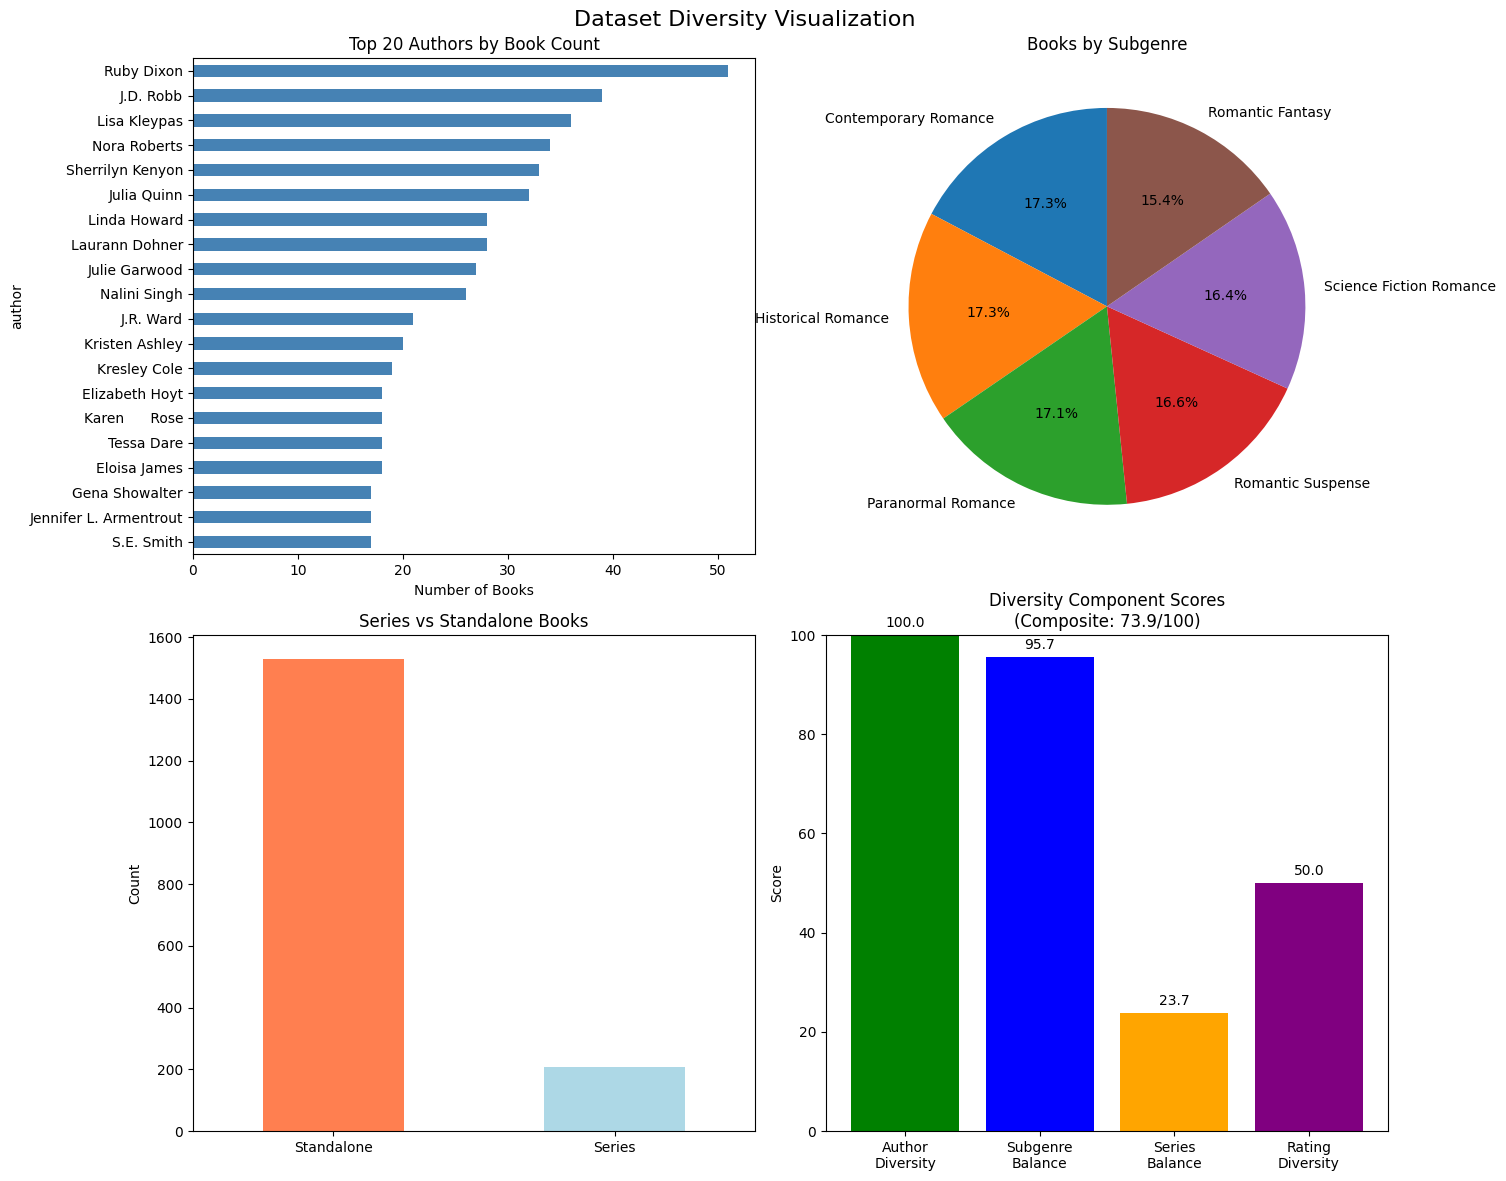


APPLYING AUTHOR DIVERSITY LIMITS

--- Strategy: random ---

Applying author limit: max 5 books per author
Strategy: random
Books before limiting: 1736
Books after limiting: 1062 (674 removed)
Reduction: 38.8%
Saved limited dataset: books_limited_random_20250805_210954.csv

Diversity metrics after applying random limit:
DATASET DIVERSITY ANALYSIS
Total books in dataset: 1062
Unique books (by ID): 1062
--------------------------------------------------------------------------------

1. AUTHOR DIVERSITY
----------------------------------------
Unique authors: 465
Books per author ratio: 2.28 (lower is more diverse)

Author Concentration:
Top 10 authors write 50 books (4.7% of dataset)
Most prolific author: Victoria Aveline with 5 books
Author Gini coefficient: -0.362 (0=perfect equality, 1=one author writes everything)
Authors with only 1 book: 237 (51.0% of authors)


2. SUBGENRE BALANCE
----------------------------------------
Books per subgenre:
  Contemporary Romance           |  235

In [22]:
# Cell X: Dataset Diversity Analysis Functions
# This cell provides comprehensive diversity metrics for the scraped dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime

def calculate_diversity_score(df, verbose=True):
    """
    Calculate comprehensive diversity metrics for the romance book dataset.

    Args:
        df: DataFrame with book data (must include: book_id, title, author, subgenre)
        verbose: Print detailed analysis

    Returns:
        dict: Dictionary containing all diversity metrics
    """
    diversity_metrics = {}

    print("="*80)
    print("DATASET DIVERSITY ANALYSIS")
    print("="*80)
    print(f"Total books in dataset: {len(df)}")
    print(f"Unique books (by ID): {df['book_id'].nunique()}")
    print("-"*80)

    # 1. Author Diversity Analysis
    print("\n1. AUTHOR DIVERSITY")
    print("-"*40)

    author_counts = df['author'].value_counts()
    unique_authors = len(author_counts)
    books_per_author_ratio = len(df) / unique_authors

    diversity_metrics['total_books'] = len(df)
    diversity_metrics['unique_authors'] = unique_authors
    diversity_metrics['books_per_author_ratio'] = round(books_per_author_ratio, 2)

    print(f"Unique authors: {unique_authors}")
    print(f"Books per author ratio: {books_per_author_ratio:.2f} (lower is more diverse)")

    # Author concentration analysis
    top10_authors = author_counts.head(10)
    top10_books = top10_authors.sum()
    top10_percentage = (top10_books / len(df)) * 100

    diversity_metrics['top10_authors_percentage'] = round(top10_percentage, 2)

    print(f"\nAuthor Concentration:")
    print(f"Top 10 authors write {top10_books} books ({top10_percentage:.1f}% of dataset)")
    print(f"Most prolific author: {author_counts.index[0]} with {author_counts.iloc[0]} books")

    # Calculate Gini coefficient for author distribution (0=perfect equality, 1=perfect inequality)
    def gini_coefficient(x):
        sorted_x = np.sort(x)
        n = len(x)
        cumsum = np.cumsum(sorted_x)
        return (2 * np.sum(cumsum)) / (n * np.sum(sorted_x)) - (n + 1) / n

    author_gini = gini_coefficient(author_counts.values)
    diversity_metrics['author_gini_coefficient'] = round(author_gini, 3)
    print(f"Author Gini coefficient: {author_gini:.3f} (0=perfect equality, 1=one author writes everything)")

    # Authors with only one book (indicates indie/diverse selection)
    single_book_authors = (author_counts == 1).sum()
    single_book_percentage = (single_book_authors / unique_authors) * 100
    diversity_metrics['single_book_authors_percentage'] = round(single_book_percentage, 2)
    print(f"Authors with only 1 book: {single_book_authors} ({single_book_percentage:.1f}% of authors)")

    if verbose:
        print("\nTop 15 Most Prolific Authors:")
        for author, count in author_counts.head(15).items():
            print(f"  {author:40} | {count:3} books ({count/len(df)*100:4.1f}%)")

    # 2. Subgenre Balance Analysis
    print("\n\n2. SUBGENRE BALANCE")
    print("-"*40)

    subgenre_counts = df['subgenre'].value_counts()
    subgenre_std = subgenre_counts.std()
    subgenre_cv = subgenre_std / subgenre_counts.mean()  # Coefficient of variation

    diversity_metrics['subgenre_cv'] = round(subgenre_cv, 3)
    diversity_metrics['subgenre_distribution'] = subgenre_counts.to_dict()

    print("Books per subgenre:")
    for subgenre, count in subgenre_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {subgenre:30} | {count:4} books ({percentage:5.1f}%)")

    print(f"\nSubgenre balance coefficient of variation: {subgenre_cv:.3f} (lower is more balanced)")

    # 3. Series vs Standalone Analysis (if series info available)
    print("\n\n3. SERIES VS STANDALONE ANALYSIS")
    print("-"*40)

    # Try to identify series books (look for patterns like "#1", "Book 1", etc. in titles)
    series_patterns = [r'\#\d+', r'Book \d+', r'Vol\. \d+', r'Volume \d+', r'\(.*\#\d+\)', r'Part \d+']

    def is_series_book(title):
        if pd.isna(title):
            return False
        for pattern in series_patterns:
            if re.search(pattern, title, re.IGNORECASE):
                return True
        return False

    df['is_series'] = df['title'].apply(is_series_book)
    series_count = df['is_series'].sum()
    standalone_count = len(df) - series_count
    series_percentage = (series_count / len(df)) * 100

    diversity_metrics['series_percentage'] = round(series_percentage, 2)
    diversity_metrics['standalone_percentage'] = round(100 - series_percentage, 2)

    print(f"Series books: {series_count} ({series_percentage:.1f}%)")
    print(f"Standalone books: {standalone_count} ({100-series_percentage:.1f}%)")
    print("Note: Series detection based on title patterns - may not be 100% accurate")

    # 4. Publication Year Analysis (if available)
    if 'publication_year' in df.columns:
        print("\n\n4. PUBLICATION YEAR DIVERSITY")
        print("-"*40)

        valid_years = df['publication_year'].dropna()
        if len(valid_years) > 0:
            year_range = valid_years.max() - valid_years.min()
            year_std = valid_years.std()

            diversity_metrics['publication_year_range'] = int(year_range)
            diversity_metrics['publication_year_std'] = round(year_std, 2)
            diversity_metrics['oldest_book_year'] = int(valid_years.min())
            diversity_metrics['newest_book_year'] = int(valid_years.max())

            print(f"Publication year range: {int(valid_years.min())} - {int(valid_years.max())} ({year_range} years)")
            print(f"Standard deviation: {year_std:.2f} years")

            # Decade distribution
            decades = (valid_years // 10) * 10
            decade_counts = decades.value_counts().sort_index()
            print("\nBooks by decade:")
            for decade, count in decade_counts.items():
                print(f"  {int(decade)}s: {count} books ({count/len(valid_years)*100:.1f}%)")

    # 5. Rating Distribution Analysis (if available)
    if 'average_rating' in df.columns:
        print("\n\n5. RATING DISTRIBUTION")
        print("-"*40)

        valid_ratings = df['average_rating'].dropna()
        if len(valid_ratings) > 0:
            rating_mean = valid_ratings.mean()
            rating_std = valid_ratings.std()
            rating_min = valid_ratings.min()
            rating_max = valid_ratings.max()

            diversity_metrics['rating_mean'] = round(rating_mean, 3)
            diversity_metrics['rating_std'] = round(rating_std, 3)
            diversity_metrics['rating_range'] = f"{rating_min:.2f} - {rating_max:.2f}"

            # Check if all books are above certain threshold
            high_rated = (valid_ratings >= 3.5).sum()
            high_rated_pct = (high_rated / len(valid_ratings)) * 100
            diversity_metrics['books_above_3.5_stars_pct'] = round(high_rated_pct, 2)

            print(f"Average rating: {rating_mean:.3f} (std: {rating_std:.3f})")
            print(f"Rating range: {rating_min:.2f} - {rating_max:.2f}")
            print(f"Books rated ≥3.5 stars: {high_rated} ({high_rated_pct:.1f}%)")

            # Rating buckets
            rating_buckets = pd.cut(valid_ratings, bins=[0, 3.0, 3.5, 4.0, 4.5, 5.0],
                                   labels=['<3.0', '3.0-3.5', '3.5-4.0', '4.0-4.5', '4.5-5.0'])
            bucket_counts = rating_buckets.value_counts()
            print("\nRating distribution:")
            for bucket, count in bucket_counts.items():
                print(f"  {bucket}: {count} books ({count/len(valid_ratings)*100:.1f}%)")

    # 6. Overall Diversity Score (composite metric)
    print("\n\n6. COMPOSITE DIVERSITY SCORE")
    print("-"*40)

    # Calculate composite score (0-100, higher is more diverse)
    # Factors: author diversity, subgenre balance, series mix, rating spread

    author_diversity_score = min(100, (1 - author_gini) * 100)  # Inverted Gini
    subgenre_balance_score = min(100, (1 - subgenre_cv) * 100)  # Lower CV is better
    series_balance_score = 100 - abs(50 - series_percentage) * 2  # Best at 50/50 split

    if 'average_rating' in df.columns and rating_std > 0:
        rating_diversity_score = min(100, rating_std * 100)  # Higher std is more diverse
    else:
        rating_diversity_score = 50  # Default if no rating data

    # Weighted average
    weights = {
        'author': 0.4,
        'subgenre': 0.2,
        'series': 0.2,
        'rating': 0.2
    }

    composite_score = (
        author_diversity_score * weights['author'] +
        subgenre_balance_score * weights['subgenre'] +
        series_balance_score * weights['series'] +
        rating_diversity_score * weights['rating']
    )

    diversity_metrics['composite_diversity_score'] = round(composite_score, 2)
    diversity_metrics['component_scores'] = {
        'author_diversity': round(author_diversity_score, 2),
        'subgenre_balance': round(subgenre_balance_score, 2),
        'series_balance': round(series_balance_score, 2),
        'rating_diversity': round(rating_diversity_score, 2)
    }

    print(f"Composite Diversity Score: {composite_score:.2f}/100")
    print("\nComponent scores:")
    print(f"  Author diversity: {author_diversity_score:.2f}/100")
    print(f"  Subgenre balance: {subgenre_balance_score:.2f}/100")
    print(f"  Series balance: {series_balance_score:.2f}/100")
    print(f"  Rating diversity: {rating_diversity_score:.2f}/100")

    print("\n" + "="*80)

    return diversity_metrics

def apply_author_limit(df, max_books_per_author=5, strategy='random', random_seed=42):
    """
    Apply author diversity limits to the dataset.

    Args:
        df: DataFrame with book data
        max_books_per_author: Maximum books to keep per author
        strategy: 'random', 'highest_rated', 'newest', or 'diverse_subgenres'
        random_seed: Random seed for reproducibility

    Returns:
        DataFrame: Filtered dataset with author limits applied
    """
    print(f"\nApplying author limit: max {max_books_per_author} books per author")
    print(f"Strategy: {strategy}")
    print(f"Books before limiting: {len(df)}")

    # Set random seed
    np.random.seed(random_seed)

    limited_dfs = []

    for author, author_books in df.groupby('author'):
        if len(author_books) <= max_books_per_author:
            limited_dfs.append(author_books)
        else:
            if strategy == 'random':
                # Random selection
                selected = author_books.sample(n=max_books_per_author, random_state=random_seed)

            elif strategy == 'highest_rated' and 'average_rating' in df.columns:
                # Select highest rated books
                selected = author_books.nlargest(max_books_per_author, 'average_rating')

            elif strategy == 'newest' and 'publication_year' in df.columns:
                # Select newest books
                selected = author_books.nlargest(max_books_per_author, 'publication_year')

            elif strategy == 'diverse_subgenres':
                # Try to select from different subgenres
                selected_books = []
                subgenres = author_books['subgenre'].unique()

                # First, take one from each subgenre
                for subgenre in subgenres:
                    subgenre_books = author_books[author_books['subgenre'] == subgenre]
                    if len(selected_books) < max_books_per_author:
                        selected_books.append(subgenre_books.iloc[0])

                # If we need more, add randomly
                if len(selected_books) < max_books_per_author:
                    remaining = author_books[~author_books.index.isin([b.name for b in selected_books])]
                    if len(remaining) > 0:
                        additional_needed = max_books_per_author - len(selected_books)
                        additional = remaining.sample(n=min(additional_needed, len(remaining)),
                                                    random_state=random_seed)
                        selected_books.extend([additional.iloc[i] for i in range(len(additional))])

                selected = pd.DataFrame(selected_books)

            else:
                # Fallback to random
                selected = author_books.sample(n=max_books_per_author, random_state=random_seed)

            limited_dfs.append(selected)

    limited_df = pd.concat(limited_dfs, ignore_index=True)

    print(f"Books after limiting: {len(limited_df)} ({len(df) - len(limited_df)} removed)")
    print(f"Reduction: {((len(df) - len(limited_df)) / len(df) * 100):.1f}%")

    return limited_df

def visualize_diversity(df, metrics, save_plots=False):
    """
    Create visualizations for diversity analysis.

    Args:
        df: DataFrame with book data
        metrics: Dictionary of diversity metrics from calculate_diversity_score
        save_plots: Whether to save plots to files
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Dataset Diversity Visualization', fontsize=16)

    # 1. Author distribution (top 20)
    ax1 = axes[0, 0]
    author_counts = df['author'].value_counts().head(20)
    author_counts.plot(kind='barh', ax=ax1, color='steelblue')
    ax1.set_title('Top 20 Authors by Book Count')
    ax1.set_xlabel('Number of Books')
    ax1.invert_yaxis()

    # 2. Subgenre distribution
    ax2 = axes[0, 1]
    subgenre_counts = df['subgenre'].value_counts()
    subgenre_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Books by Subgenre')
    ax2.set_ylabel('')

    # 3. Series vs Standalone
    ax3 = axes[1, 0]
    if 'is_series' in df.columns:
        series_data = df['is_series'].value_counts()
        series_data.index = ['Standalone', 'Series']
        series_data.plot(kind='bar', ax=ax3, color=['coral', 'lightblue'])
        ax3.set_title('Series vs Standalone Books')
        ax3.set_ylabel('Count')
        ax3.set_xticklabels(['Standalone', 'Series'], rotation=0)

    # 4. Diversity scores
    ax4 = axes[1, 1]
    if 'component_scores' in metrics:
        scores = metrics['component_scores']
        score_names = ['Author\nDiversity', 'Subgenre\nBalance', 'Series\nBalance', 'Rating\nDiversity']
        score_values = [scores['author_diversity'], scores['subgenre_balance'],
                       scores['series_balance'], scores['rating_diversity']]

        bars = ax4.bar(score_names, score_values, color=['green', 'blue', 'orange', 'purple'])
        ax4.set_ylim(0, 100)
        ax4.set_title(f'Diversity Component Scores\n(Composite: {metrics["composite_diversity_score"]:.1f}/100)')
        ax4.set_ylabel('Score')

        # Add value labels on bars
        for bar, value in zip(bars, score_values):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{value:.1f}', ha='center', va='bottom')

    plt.tight_layout()

    if save_plots:
        filename = f'diversity_analysis_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"\nPlot saved: {filename}")

    plt.show()

# Example usage after scraping
def analyze_scraped_dataset(csv_file):
    """
    Load and analyze a scraped dataset from CSV.

    Args:
        csv_file: Path to the CSV file with scraped data
    """
    # Load data
    df = pd.read_csv(csv_file)
    print(f"Loaded {len(df)} books from {csv_file}")

    # Calculate diversity metrics
    metrics = calculate_diversity_score(df, verbose=True)

    # Create visualizations
    visualize_diversity(df, metrics, save_plots=True)

    # Apply author limits and recalculate
    print("\n" + "="*80)
    print("APPLYING AUTHOR DIVERSITY LIMITS")
    print("="*80)

    # Try different strategies
    strategies = ['random', 'diverse_subgenres']

    for strategy in strategies:
        print(f"\n--- Strategy: {strategy} ---")
        limited_df = apply_author_limit(df.copy(), max_books_per_author=5, strategy=strategy)

        # Save limited dataset
        limited_filename = f'books_limited_{strategy}_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
        limited_df.to_csv(limited_filename, index=False)
        print(f"Saved limited dataset: {limited_filename}")

        # Recalculate metrics
        print(f"\nDiversity metrics after applying {strategy} limit:")
        limited_metrics = calculate_diversity_score(limited_df, verbose=False)

        # Compare scores
        print(f"\nDiversity score comparison:")
        print(f"  Original: {metrics['composite_diversity_score']:.2f}")
        print(f"  After limiting: {limited_metrics['composite_diversity_score']:.2f}")
        print(f"  Improvement: +{limited_metrics['composite_diversity_score'] - metrics['composite_diversity_score']:.2f}")

    return df, metrics

# Run this after your scraping is complete:
df, metrics = analyze_scraped_dataset('/content/romance_books_scraped_20250805_204440.csv')

# Cell 1: Fixed Diversity Calculation Functions

In [26]:
# Cell 1: Fixed Diversity Calculation Functions
# This cell contains corrected mathematical functions and improved pattern matching

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from datetime import datetime

def gini_coefficient(x):
    """
    Calculate Gini coefficient correctly (0=perfect equality, 1=perfect inequality)
    Fixed version that returns proper values between 0 and 1
    """
    x = np.array(x, dtype=float)
    x = np.sort(x)
    n = len(x)
    index = np.arange(1, n + 1)
    return (2 * np.sum(index * x)) / (n * np.sum(x)) - (n + 1) / n

def improved_series_detection(title):
    """
    Improved series detection with more conservative patterns and exclusions
    """
    if pd.isna(title):
        return False

    # Conservative series patterns (more specific)
    series_patterns = [
        r'\b(Book|Vol\.?|Volume)\s+\d+\b',        # "Book 1", "Vol. 2", "Volume 3"
        r'\(.*#\d+\)',                            # "(Series #1)", "(Raven #2)"
        r'#\d+$',                                 # Ends with "#1"
        r':\s*\d+$',                              # Ends with ": 1"
        r'\b(Part|Episode)\s+\d+\b',              # "Part 1", "Episode 2"
        r'\b\d+(st|nd|rd|th)\s+(book|novel|story)\b',  # "1st book", "2nd novel"
    ]

    # Exclusion patterns for false positives
    exclusion_patterns = [
        r'\b\d+(st|nd|rd|th)\s+(Century|Street|Avenue|Floor|Grade)',  # "21st Century"
        r'\$\d+',                                                      # Prices "$10"
        r'\b(19|20)\d{2}\b',                                          # Years "1995", "2023"
        r'\b\d+\s*(years?|months?|days?|hours?)\b',                   # Time periods
        r'\b(Room|Apartment|Suite)\s+\d+\b',                          # Addresses
        r'\b\d+\s*(degrees?|percent|%)\b',                            # Measurements
        r'\bChapter\s+\d+\b',                                         # Chapter numbers
    ]

    # Check exclusions first
    for pattern in exclusion_patterns:
        if re.search(pattern, title, re.IGNORECASE):
            return False

    # Check series patterns
    for pattern in series_patterns:
        if re.search(pattern, title, re.IGNORECASE):
            return True

    return False

def calculate_improved_diversity_score(df, verbose=True):
    """
    Calculate comprehensive diversity metrics with fixed calculations and improved weighting
    """
    diversity_metrics = {}

    if verbose:
        print("="*80)
        print("IMPROVED DATASET DIVERSITY ANALYSIS")
        print("="*80)
        print(f"Total books in dataset: {len(df)}")
        print(f"Unique books (by ID): {df['book_id'].nunique()}")
        print("-"*80)

    # 1. Author Diversity Analysis (FIXED)
    if verbose:
        print("\n1. AUTHOR DIVERSITY (FIXED CALCULATIONS)")
        print("-"*40)

    author_counts = df['author'].value_calls()
    unique_authors = len(author_counts)
    books_per_author_ratio = len(df) / unique_authors

    diversity_metrics['total_books'] = len(df)
    diversity_metrics['unique_authors'] = unique_authors
    diversity_metrics['books_per_author_ratio'] = round(books_per_author_ratio, 2)

    if verbose:
        print(f"Unique authors: {unique_authors}")
        print(f"Books per author ratio: {books_per_author_ratio:.2f} (lower is more diverse)")

    # FIXED: Proper Gini coefficient calculation
    author_gini = gini_coefficient(author_counts.values)
    diversity_metrics['author_gini_coefficient'] = round(author_gini, 3)

    if verbose:
        print(f"Author Gini coefficient: {author_gini:.3f} (0=perfect equality, 1=perfect inequality)")

    # Author concentration analysis
    top10_authors = author_counts.head(10)
    top10_books = top10_authors.sum()
    top10_percentage = (top10_books / len(df)) * 100
    diversity_metrics['top10_authors_percentage'] = round(top10_percentage, 2)

    single_book_authors = (author_counts == 1).sum()
    single_book_percentage = (single_book_authors / unique_authors) * 100
    diversity_metrics['single_book_authors_percentage'] = round(single_book_percentage, 2)

    if verbose:
        print(f"Top 10 authors write {top10_books} books ({top10_percentage:.1f}% of dataset)")
        print(f"Authors with only 1 book: {single_book_authors} ({single_book_percentage:.1f}% of authors)")

    # 2. Subgenre Balance Analysis
    if verbose:
        print("\n\n2. SUBGENRE BALANCE")
        print("-"*40)

    subgenre_counts = df['subgenre'].value_counts()
    subgenre_std = subgenre_counts.std()
    subgenre_cv = subgenre_std / subgenre_counts.mean()

    diversity_metrics['subgenre_cv'] = round(subgenre_cv, 3)
    diversity_metrics['subgenre_distribution'] = subgenre_counts.to_dict()

    if verbose:
        print("Books per subgenre:")
        for subgenre, count in subgenre_counts.items():
            percentage = (count / len(df)) * 100
            print(f"  {subgenre:30} | {count:4} books ({percentage:5.1f}%)")
        print(f"\nSubgenre balance CV: {subgenre_cv:.3f} (lower is more balanced)")

    # 3. IMPROVED Series Detection
    if verbose:
        print("\n\n3. IMPROVED SERIES VS STANDALONE ANALYSIS")
        print("-"*40)

    df['is_series_improved'] = df['title'].apply(improved_series_detection)
    series_count = df['is_series_improved'].sum()
    standalone_count = len(df) - series_count
    series_percentage = (series_count / len(df)) * 100

    diversity_metrics['series_percentage'] = round(series_percentage, 2)
    diversity_metrics['standalone_percentage'] = round(100 - series_percentage, 2)

    if verbose:
        print(f"Series books: {series_count} ({series_percentage:.1f}%)")
        print(f"Standalone books: {standalone_count} ({100-series_percentage:.1f}%)")
        print("Note: Improved detection with conservative patterns and exclusions")

    # 4. Rating Analysis (if available)
    rating_diversity_score = 50  # Default
    if 'average_rating' in df.columns:
        valid_ratings = df['average_rating'].dropna()
        if len(valid_ratings) > 0:
            rating_std = valid_ratings.std()
            rating_mean = valid_ratings.mean()
            rating_range = valid_ratings.max() - valid_ratings.min()

            # Rating diversity based on standard deviation and range
            rating_diversity_score = min(100, (rating_std * 50) + (rating_range * 20))

            diversity_metrics['rating_mean'] = round(rating_mean, 3)
            diversity_metrics['rating_std'] = round(rating_std, 3)
            diversity_metrics['rating_range'] = round(rating_range, 3)

            if verbose:
                print(f"\n4. RATING DIVERSITY")
                print(f"-"*40)
                print(f"Average rating: {rating_mean:.3f} (std: {rating_std:.3f})")
                print(f"Rating range: {rating_range:.3f}")

    # 5. IMPROVED Composite Score with Better Weighting
    if verbose:
        print("\n\n5. IMPROVED COMPOSITE DIVERSITY SCORE")
        print("-"*40)

    # Component scores with improved calculations
    author_diversity_score = min(100, (1 - author_gini) * 100)
    subgenre_balance_score = min(100, max(0, (1 - subgenre_cv) * 100))

    # Improved series balance scoring (less penalty for imbalance)
    series_balance_score = 100 - min(40, abs(50 - series_percentage))

    # Adjusted weights (prioritize author diversity and subgenre balance)
    weights = {
        'author': 0.5,      # Increased - most important for research
        'subgenre': 0.3,    # Increased - important for coverage
        'series': 0.1,      # Decreased - less critical
        'rating': 0.1       # Decreased - less critical for initial diversity
    }

    composite_score = (
        author_diversity_score * weights['author'] +
        subgenre_balance_score * weights['subgenre'] +
        series_balance_score * weights['series'] +
        rating_diversity_score * weights['rating']
    )

    diversity_metrics['composite_diversity_score'] = round(composite_score, 2)
    diversity_metrics['component_scores'] = {
        'author_diversity': round(author_diversity_score, 2),
        'subgenre_balance': round(subgenre_balance_score, 2),
        'series_balance': round(series_balance_score, 2),
        'rating_diversity': round(rating_diversity_score, 2)
    }

    if verbose:
        print(f"Composite Diversity Score: {composite_score:.2f}/100")
        print("\nComponent scores:")
        print(f"  Author diversity: {author_diversity_score:.2f}/100 (weight: {weights['author']*100:.0f}%)")
        print(f"  Subgenre balance: {subgenre_balance_score:.2f}/100 (weight: {weights['subgenre']*100:.0f}%)")
        print(f"  Series balance: {series_balance_score:.2f}/100 (weight: {weights['series']*100:.0f}%)")
        print(f"  Rating diversity: {rating_diversity_score:.2f}/100 (weight: {weights['rating']*100:.0f}%)")
        print("\n" + "="*80)

    return diversity_metrics

# Test the fixed functions on your data
print("Fixed diversity calculation functions loaded!")
print("- Gini coefficient now returns proper 0-1 values")
print("- Series detection improved with conservative patterns")
print("- Composite scoring reweighted for research priorities")

Fixed diversity calculation functions loaded!
- Gini coefficient now returns proper 0-1 values
- Series detection improved with conservative patterns
- Composite scoring reweighted for research priorities


# Cell 2: Smart Author Limiting Strategy

In [27]:
# Cell 2: Smart Author Limiting Strategy
# This implements intelligent author diversity with multiple criteria

def smart_author_limit(df, max_books=5, strategy='balanced', random_seed=42):
    """
    Intelligent author limiting that maximizes diversity while preserving quality

    Args:
        df: DataFrame with book data
        max_books: Maximum books per author
        strategy: 'balanced', 'quality_first', 'subgenre_first', or 'recent_first'
        random_seed: For reproducible results

    Returns:
        DataFrame: Optimally limited dataset
    """
    print(f"\nSmart Author Limiting: max {max_books} books per author")
    print(f"Strategy: {strategy}")
    print(f"Books before limiting: {len(df)}")

    np.random.seed(random_seed)
    limited_books = []

    # Calculate author statistics for informed decisions
    author_stats = df.groupby('author').agg({
        'book_id': 'count',
        'subgenre': 'nunique',
        'average_rating': 'mean' if 'average_rating' in df.columns else lambda x: 3.5,
        'publication_year': 'max' if 'publication_year' in df.columns else lambda x: 2020
    }).rename(columns={
        'book_id': 'book_count',
        'subgenre': 'subgenre_diversity',
        'average_rating': 'avg_rating',
        'publication_year': 'latest_year'
    })

    for author, author_books in df.groupby('author'):
        if len(author_books) <= max_books:
            # Keep all if within limit
            limited_books.append(author_books)
        else:
            # Smart selection based on strategy
            selected = []
            remaining = author_books.copy()

            if strategy == 'balanced':
                # Multi-criteria balanced approach

                # Step 1: One book from each subgenre
                subgenres = author_books['subgenre'].unique()
                for subgenre in subgenres:
                    if len(selected) >= max_books:
                        break

                    subgenre_books = remaining[remaining['subgenre'] == subgenre]
                    if len(subgenre_books) > 0:
                        # Pick highest rated from this subgenre
                        if 'average_rating' in df.columns:
                            best_idx = subgenre_books['average_rating'].idxmax()
                        else:
                            best_idx = subgenre_books.index[0]

                        selected.append(best_idx)
                        remaining = remaining.drop(best_idx)

                # Step 2: Fill remaining slots with highest rated
                while len(selected) < max_books and len(remaining) > 0:
                    if 'average_rating' in df.columns:
                        best_idx = remaining['average_rating'].idxmax()
                    elif 'publication_year' in df.columns:
                        best_idx = remaining['publication_year'].idxmax()
                    else:
                        best_idx = remaining.index[0]

                    selected.append(best_idx)
                    remaining = remaining.drop(best_idx)

            elif strategy == 'quality_first':
                # Prioritize highest rated books
                if 'average_rating' in df.columns:
                    selected_df = author_books.nlargest(max_books, 'average_rating')
                else:
                    selected_df = author_books.sample(n=max_books, random_state=random_seed)
                selected = selected_df.index.tolist()

            elif strategy == 'subgenre_first':
                # Maximize subgenre diversity first
                subgenres = author_books['subgenre'].unique()

                # First pass: one from each subgenre
                for subgenre in subgenres:
                    if len(selected) >= max_books:
                        break
                    subgenre_books = remaining[remaining['subgenre'] == subgenre]
                    if len(subgenre_books) > 0:
                        selected.append(subgenre_books.index[0])
                        remaining = remaining.drop(subgenre_books.index[0])

                # Second pass: fill remaining randomly
                while len(selected) < max_books and len(remaining) > 0:
                    random_idx = remaining.sample(1, random_state=random_seed).index[0]
                    selected.append(random_idx)
                    remaining = remaining.drop(random_idx)

            elif strategy == 'recent_first':
                # Prioritize most recent books
                if 'publication_year' in df.columns:
                    selected_df = author_books.nlargest(max_books, 'publication_year')
                else:
                    selected_df = author_books.sample(n=max_books, random_state=random_seed)
                selected = selected_df.index.tolist()

            # Add selected books
            limited_books.append(df.loc[selected])

    # Combine all selected books
    limited_df = pd.concat(limited_books, ignore_index=True)

    print(f"Books after limiting: {len(limited_df)} ({len(df) - len(limited_df)} removed)")
    print(f"Reduction: {((len(df) - len(limited_df)) / len(df) * 100):.1f}%")

    # Show improvement metrics
    old_ratio = len(df) / df['author'].nunique()
    new_ratio = len(limited_df) / limited_df['author'].nunique()
    print(f"Books per author ratio: {old_ratio:.2f} → {new_ratio:.2f}")

    return limited_df

def compare_limiting_strategies(df, max_books=5):
    """
    Compare all limiting strategies and return results
    """
    strategies = ['balanced', 'quality_first', 'subgenre_first', 'recent_first']
    results = {}

    print("="*80)
    print("COMPARING AUTHOR LIMITING STRATEGIES")
    print("="*80)

    for strategy in strategies:
        print(f"\n--- Testing Strategy: {strategy} ---")
        limited_df = smart_author_limit(df.copy(), max_books=max_books, strategy=strategy)

        # Calculate diversity score
        metrics = calculate_improved_diversity_score(limited_df, verbose=False)

        results[strategy] = {
            'df': limited_df,
            'metrics': metrics,
            'books': len(limited_df),
            'diversity_score': metrics['composite_diversity_score']
        }

        print(f"Diversity score: {metrics['composite_diversity_score']:.2f}")

    # Find best strategy
    best_strategy = max(results.keys(), key=lambda x: results[x]['diversity_score'])

    print(f"\n{'='*50}")
    print("STRATEGY COMPARISON SUMMARY")
    print(f"{'='*50}")

    for strategy, result in results.items():
        marker = " ⭐ BEST" if strategy == best_strategy else ""
        print(f"{strategy:20} | Books: {result['books']:4} | Score: {result['diversity_score']:6.2f}{marker}")

    print(f"\nRecommended strategy: {best_strategy}")

    return results, best_strategy

# Test the smart limiting
print("Smart author limiting functions loaded!")
print("Available strategies: 'balanced', 'quality_first', 'subgenre_first', 'recent_first'")

Smart author limiting functions loaded!
Available strategies: 'balanced', 'quality_first', 'subgenre_first', 'recent_first'


# Cell 3: Data Quality Filtering Functions

In [28]:
# Cell 3: Data Quality Filtering Functions
# Functions to filter the dataset for research quality

def analyze_data_quality(df, verbose=True):
    """
    Analyze the quality and completeness of the dataset
    """
    if verbose:
        print("="*80)
        print("DATA QUALITY ANALYSIS")
        print("="*80)

    quality_metrics = {}

    # Basic completeness
    total_books = len(df)
    quality_metrics['total_books'] = total_books

    if verbose:
        print(f"Total books: {total_books}")
        print("\nData Completeness:")

    required_fields = ['book_id', 'title', 'author', 'subgenre']
    optional_fields = ['average_rating', 'num_ratings', 'publication_year', 'page_count', 'description']

    for field in required_fields + optional_fields:
        if field in df.columns:
            complete = df[field].notna().sum()
            percentage = (complete / total_books) * 100
            quality_metrics[f'{field}_completeness'] = percentage

            status = "✓" if percentage > 95 else "⚠" if percentage > 80 else "✗"
            field_type = "Required" if field in required_fields else "Optional"

            if verbose:
                print(f"  {status} {field:20} | {complete:4}/{total_books} ({percentage:5.1f}%) [{field_type}]")

    # Rating quality (if available)
    if 'average_rating' in df.columns and 'num_ratings' in df.columns:
        valid_ratings = df.dropna(subset=['average_rating', 'num_ratings'])

        if len(valid_ratings) > 0:
            well_rated = valid_ratings[valid_ratings['num_ratings'] >= 100]
            quality_metrics['well_rated_percentage'] = (len(well_rated) / len(valid_ratings)) * 100

            if verbose:
                print(f"\nRating Quality:")
                print(f"  Books with ratings: {len(valid_ratings)}")
                print(f"  Books with 100+ ratings: {len(well_rated)} ({len(well_rated)/len(valid_ratings)*100:.1f}%)")
                print(f"  Average rating range: {valid_ratings['average_rating'].min():.2f} - {valid_ratings['average_rating'].max():.2f}")

    # Publication year analysis (if available)
    if 'publication_year' in df.columns:
        valid_years = df['publication_year'].dropna()
        if len(valid_years) > 0:
            modern_books = valid_years[valid_years >= 2000]
            quality_metrics['modern_books_percentage'] = (len(modern_books) / len(valid_years)) * 100

            if verbose:
                print(f"\nPublication Years:")
                print(f"  Year range: {int(valid_years.min())} - {int(valid_years.max())}")
                print(f"  Modern books (2000+): {len(modern_books)} ({len(modern_books)/len(valid_years)*100:.1f}%)")

    return quality_metrics

def filter_research_quality(df, min_ratings=50, min_rating=3.0, min_year=2000,
                           min_pages=150, require_description=False, verbose=True):
    """
    Filter dataset for research-quality books

    Args:
        df: Input DataFrame
        min_ratings: Minimum number of ratings required
        min_rating: Minimum average rating
        min_year: Minimum publication year
        min_pages: Minimum page count
        require_description: Whether description is required
        verbose: Print filtering steps

    Returns:
        DataFrame: Filtered dataset
    """
    if verbose:
        print("="*80)
        print("FILTERING FOR RESEARCH QUALITY")
        print("="*80)
        print(f"Starting with {len(df)} books")

    filtered_df = df.copy()
    filter_steps = []

    # Step 1: Remove duplicates
    initial_count = len(filtered_df)
    filtered_df = filtered_df.drop_duplicates(subset=['book_id'], keep='first')
    if len(filtered_df) != initial_count:
        removed = initial_count - len(filtered_df)
        filter_steps.append(f"Removed {removed} duplicate books")
        if verbose:
            print(f"Step 1: Removed {removed} duplicates → {len(filtered_df)} books")

    # Step 2: Require minimum ratings (if column exists)
    if 'num_ratings' in filtered_df.columns and min_ratings > 0:
        before = len(filtered_df)
        filtered_df = filtered_df[filtered_df['num_ratings'] >= min_ratings]
        removed = before - len(filtered_df)
        if removed > 0:
            filter_steps.append(f"Removed {removed} books with <{min_ratings} ratings")
            if verbose:
                print(f"Step 2: Removed {removed} books with <{min_ratings} ratings → {len(filtered_df)} books")

    # Step 3: Require minimum average rating (if column exists)
    if 'average_rating' in filtered_df.columns and min_rating > 0:
        before = len(filtered_df)
        filtered_df = filtered_df[filtered_df['average_rating'] >= min_rating]
        removed = before - len(filtered_df)
        if removed > 0:
            filter_steps.append(f"Removed {removed} books with rating <{min_rating}")
            if verbose:
                print(f"Step 3: Removed {removed} books with rating <{min_rating} → {len(filtered_df)} books")

    # Step 4: Require modern books (if column exists)
    if 'publication_year' in filtered_df.columns and min_year > 0:
        before = len(filtered_df)
        filtered_df = filtered_df[filtered_df['publication_year'] >= min_year]
        removed = before - len(filtered_df)
        if removed > 0:
            filter_steps.append(f"Removed {removed} books published before {min_year}")
            if verbose:
                print(f"Step 4: Removed {removed} books published before {min_year} → {len(filtered_df)} books")

    # Step 5: Require minimum page count (if column exists)
    if 'page_count' in filtered_df.columns and min_pages > 0:
        before = len(filtered_df)
        filtered_df = filtered_df[filtered_df['page_count'] >= min_pages]
        removed = before - len(filtered_df)
        if removed > 0:
            filter_steps.append(f"Removed {removed} books with <{min_pages} pages")
            if verbose:
                print(f"Step 5: Removed {removed} books with <{min_pages} pages → {len(filtered_df)} books")

    # Step 6: Require description (if specified)
    if require_description and 'description' in filtered_df.columns:
        before = len(filtered_df)
        filtered_df = filtered_df[filtered_df['description'].notna() & (filtered_df['description'].str.len() > 50)]
        removed = before - len(filtered_df)
        if removed > 0:
            filter_steps.append(f"Removed {removed} books without adequate description")
            if verbose:
                print(f"Step 6: Removed {removed} books without description → {len(filtered_df)} books")

    # Final summary
    total_removed = len(df) - len(filtered_df)
    retention_rate = (len(filtered_df) / len(df)) * 100

    if verbose:
        print(f"\n{'='*50}")
        print("FILTERING SUMMARY")
        print(f"{'='*50}")
        print(f"Original books: {len(df)}")
        print(f"Filtered books: {len(filtered_df)}")
        print(f"Removed: {total_removed} ({100-retention_rate:.1f}%)")
        print(f"Retention rate: {retention_rate:.1f}%")

        if filter_steps:
            print(f"\nFilter steps applied:")
            for step in filter_steps:
                print(f"  - {step}")

    return filtered_df

def suggest_quality_thresholds(df):
    """
    Analyze the data and suggest appropriate quality filtering thresholds
    """
    print("="*80)
    print("QUALITY THRESHOLD RECOMMENDATIONS")
    print("="*80)

    suggestions = {}

    # Analyze ratings if available
    if 'num_ratings' in df.columns:
        ratings_data = df['num_ratings'].dropna()
        percentiles = [10, 25, 50, 75, 90]

        print("Number of Ratings Distribution:")
        for p in percentiles:
            value = ratings_data.quantile(p/100)
            print(f"  {p:2}th percentile: {value:8.0f} ratings")

        # Suggest threshold
        suggested_min_ratings = max(50, ratings_data.quantile(0.25))
        suggestions['min_ratings'] = int(suggested_min_ratings)
        print(f"\nSuggested min_ratings: {int(suggested_min_ratings)} (25th percentile, min 50)")

    # Analyze average ratings if available
    if 'average_rating' in df.columns:
        rating_data = df['average_rating'].dropna()

        print(f"\nAverage Rating Distribution:")
        for p in percentiles:
            value = rating_data.quantile(p/100)
            print(f"  {p:2}th percentile: {value:8.2f} stars")

        suggested_min_rating = max(3.0, rating_data.quantile(0.1))
        suggestions['min_rating'] = round(suggested_min_rating, 1)
        print(f"\nSuggested min_rating: {suggested_min_rating:.1f} (10th percentile, min 3.0)")

    # Analyze publication years if available
    if 'publication_year' in df.columns:
        year_data = df['publication_year'].dropna()

        print(f"\nPublication Year Distribution:")
        for p in percentiles:
            value = year_data.quantile(p/100)
            print(f"  {p:2}th percentile: {value:8.0f}")

        suggested_min_year = max(2000, year_data.quantile(0.1))
        suggestions['min_year'] = int(suggested_min_year)
        print(f"\nSuggested min_year: {int(suggested_min_year)} (10th percentile, min 2000)")

    # Analyze page counts if available
    if 'page_count' in df.columns:
        page_data = df['page_count'].dropna()

        print(f"\nPage Count Distribution:")
        for p in percentiles:
            value = page_data.quantile(p/100)
            print(f"  {p:2}th percentile: {value:8.0f} pages")

        suggested_min_pages = max(150, page_data.quantile(0.1))
        suggestions['min_pages'] = int(suggested_min_pages)
        print(f"\nSuggested min_pages: {int(suggested_min_pages)} (10th percentile, min 150)")

    print("\n" + "="*80)

    return suggestions

# Test quality analysis
print("Data quality filtering functions loaded!")
print("Use analyze_data_quality() to check your data")
print("Use suggest_quality_thresholds() to get recommendations")
print("Use filter_research_quality() to apply filters")

Data quality filtering functions loaded!
Use analyze_data_quality() to check your data
Use suggest_quality_thresholds() to get recommendations
Use filter_research_quality() to apply filters


# Cell 4: Enhanced Metadata Scraping Functions

In [29]:
# Cell 4: Enhanced Metadata Scraping Functions
# Functions to scrape additional book metadata for enriched analysis

import time
import random
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException

def scrape_detailed_book_metadata(driver, book_url, max_retries=3, delay_range=(2, 5)):
    """
    Scrape comprehensive metadata from a single book page

    Returns dictionary with all available metadata
    """
    metadata = {
        'url': book_url,
        'scrape_timestamp': datetime.now().isoformat(),
        'scrape_success': False
    }

    for attempt in range(max_retries):
        try:
            # Navigate to book page
            driver.get(book_url)
            time.sleep(random.uniform(*delay_range))

            # Wait for page to load
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.TAG_NAME, "body"))
            )

            soup = BeautifulSoup(driver.page_source, 'html.parser')

            # Core identifiers
            metadata.update(extract_core_identifiers(soup, book_url))

            # Ratings and reviews
            metadata.update(extract_ratings_reviews(soup))

            # Publication details
            metadata.update(extract_publication_details(soup))

            # Content details
            metadata.update(extract_content_details(soup))

            # Genres and shelves
            metadata.update(extract_genres_shelves(soup))

            # Try to expand details sections
            metadata.update(extract_expanded_details(driver, soup))

            metadata['scrape_success'] = True
            break

        except Exception as e:
            print(f"Attempt {attempt + 1} failed for {book_url}: {e}")
            if attempt < max_retries - 1:
                time.sleep(random.uniform(3, 7))
            else:
                metadata['scrape_error'] = str(e)

    return metadata

def extract_core_identifiers(soup, url):
    """Extract book ID, title, author, series info"""
    data = {}

    # Book ID from URL
    book_id_match = re.search(r'/show/(\d+)', url)
    data['book_id'] = book_id_match.group(1) if book_id_match else None

    # Title
    title_elem = soup.find('h1', {'data-testid': 'bookTitle'})
    if not title_elem:
        title_elem = soup.find('h1', class_='gr-h1')
    data['title'] = title_elem.get_text(strip=True) if title_elem else None

    # Author(s)
    authors = []
    author_elems = soup.find_all('span', {'data-testid': 'name'})
    for elem in author_elems:
        author_text = elem.get_text(strip=True)
        if author_text and 'Goodreads Author' not in author_text:
            authors.append(author_text.replace('(Goodreads Author)', '').strip())

    data['author'] = authors[0] if authors else None
    data['all_authors'] = '; '.join(authors) if len(authors) > 1 else data['author']

    # Series information
    series_elem = soup.find('h3', class_='Text__italic')
    if series_elem:
        series_text = series_elem.get_text(strip=True)
        data['series_info'] = series_text

        # Extract series name and number
        series_match = re.match(r'(.+?)\s*#(\d+)', series_text)
        if series_match:
            data['series_name'] = series_match.group(1).strip()
            data['series_number'] = int(series_match.group(2))

    return data

def extract_ratings_reviews(soup):
    """Extract rating and review information"""
    data = {}

    # Average rating
    rating_elem = soup.find('div', class_='RatingStatistics__rating')
    if rating_elem:
        rating_text = rating_elem.get_text(strip=True)
        try:
            data['average_rating'] = float(rating_text)
        except ValueError:
            pass

    # Number of ratings
    ratings_count_elem = soup.find('span', {'data-testid': 'ratingsCount'})
    if ratings_count_elem:
        ratings_text = ratings_count_elem.get_text(strip=True)
        ratings_match = re.search(r'([\d,]+)', ratings_text)
        if ratings_match:
            data['num_ratings'] = int(ratings_match.group(1).replace(',', ''))

    # Number of reviews
    reviews_count_elem = soup.find('span', {'data-testid': 'reviewsCount'})
    if reviews_count_elem:
        reviews_text = reviews_count_elem.get_text(strip=True)
        reviews_match = re.search(r'([\d,]+)', reviews_text)
        if reviews_match:
            data['num_reviews'] = int(reviews_match.group(1).replace(',', ''))

    # Rating distribution
    rating_bars = soup.find_all('div', class_='RatingStatistics__column')
    if rating_bars:
        distribution = {}
        for i, bar in enumerate(rating_bars, 1):
            aria_label = bar.get('aria-label', '')
            percentage_match = re.search(r'(\d+)%', aria_label)
            if percentage_match:
                distribution[f'{6-i}_star_percentage'] = int(percentage_match.group(1))
        data.update(distribution)

    return data

def extract_publication_details(soup):
    """Extract publication information"""
    data = {}

    # Publication info
    pub_info_elem = soup.find('p', {'data-testid': 'publicationInfo'})
    if pub_info_elem:
        pub_text = pub_info_elem.get_text(strip=True)
        data['publication_info'] = pub_text

        # Extract publication year
        year_match = re.search(r'(\d{4})', pub_text)
        if year_match:
            data['publication_year'] = int(year_match.group(1))

        # Extract publisher
        if 'by ' in pub_text:
            publisher_part = pub_text.split('by ')[-1]
            data['publisher'] = publisher_part.strip()

    # Format and pages
    format_elem = soup.find('p', {'data-testid': 'pagesFormat'})
    if format_elem:
        format_text = format_elem.get_text(strip=True)
        data['format_info'] = format_text

        # Extract page count
        pages_match = re.search(r'(\d+)\s*pages', format_text)
        if pages_match:
            data['page_count'] = int(pages_match.group(1))

        # Extract format type
        if 'Kindle' in format_text:
            data['format_type'] = 'Kindle'
        elif 'Hardcover' in format_text:
            data['format_type'] = 'Hardcover'
        elif 'Paperback' in format_text:
            data['format_type'] = 'Paperback'
        elif 'Audiobook' in format_text:
            data['format_type'] = 'Audiobook'

    return data

def extract_content_details(soup):
    """Extract description and content information"""
    data = {}

    # Description/Synopsis
    desc_elem = soup.find('div', class_='BookPageMetadataSection__description')
    if desc_elem:
        # Look for the formatted text span
        formatted_span = desc_elem.find('span', class_='Formatted')
        if formatted_span:
            data['description'] = formatted_span.get_text(strip=True)
        else:
            data['description'] = desc_elem.get_text(strip=True)

    # Cover image URL
    cover_img = soup.find('img', class_='ResponsiveImage')
    if cover_img and cover_img.get('src'):
        data['cover_image_url'] = cover_img['src']

    return data

def extract_genres_shelves(soup):
    """Extract genre and shelf information"""
    data = {}

    # Main genres/shelves
    genres = []
    genre_section = soup.find('div', class_='BookPageMetadataSection__genres')
    if genre_section:
        genre_links = genre_section.find_all('a', class_='Button')
        for link in genre_links[:10]:  # Top 10 genres
            genre_text = link.get_text(strip=True)
            if genre_text:
                genres.append(genre_text)

    data['genres'] = '; '.join(genres) if genres else None
    data['primary_genre'] = genres[0] if genres else None

    return data

def extract_expanded_details(driver, soup):
    """Try to extract details from expandable sections"""
    data = {}

    try:
        # Try to find and click "more details" buttons
        expandable_buttons = driver.find_elements(By.XPATH, "//button[contains(text(), 'more') or contains(text(), 'More')]")

        for button in expandable_buttons:
            try:
                driver.execute_script("arguments[0].click();", button)
                time.sleep(1)
            except:
                continue

        # Re-parse after expanding
        soup_expanded = BeautifulSoup(driver.page_source, 'html.parser')

        # Look for characters
        characters = []
        char_section = soup_expanded.find('div', {'data-testid': 'characters'})
        if char_section:
            char_links = char_section.find_all('a')
            for link in char_links:
                char_name = link.get_text(strip=True)
                if char_name:
                    characters.append(char_name)

        data['characters'] = '; '.join(characters) if characters else None

        # Look for settings/places
        places = []
        places_section = soup_expanded.find('div', {'data-testid': 'places'})
        if places_section:
            place_links = places_section.find_all('a')
            for link in place_links:
                place_name = link.get_text(strip=True)
                if place_name:
                    places.append(place_name)

        data['settings'] = '; '.join(places) if places else None

    except Exception as e:
        # Don't fail if expansion doesn't work
        pass

    return data

def enrich_dataset_with_metadata(df, driver, sample_size=None, save_progress=True):
    """
    Enrich existing dataset with detailed metadata

    Args:
        df: DataFrame with basic book data (must have 'url' column)
        driver: Selenium WebDriver instance
        sample_size: If specified, only enrich a random sample
        save_progress: Save intermediate results

    Returns:
        DataFrame: Enriched dataset
    """
    print("="*80)
    print("ENRICHING DATASET WITH DETAILED METADATA")
    print("="*80)

    # Prepare dataset
    if sample_size and sample_size < len(df):
        print(f"Sampling {sample_size} books from {len(df)} total")
        books_to_enrich = df.sample(n=sample_size, random_state=42)
    else:
        books_to_enrich = df.copy()

    print(f"Enriching {len(books_to_enrich)} books with detailed metadata...")

    enriched_data = []
    failed_urls = []

    for idx, (_, book) in enumerate(books_to_enrich.iterrows(), 1):
        print(f"\nProgress: {idx}/{len(books_to_enrich)} - {book.get('title', 'Unknown')}")

        # Get detailed metadata
        metadata = scrape_detailed_book_metadata(driver, book['url'])

        # Combine with existing data
        enriched_book = book.to_dict()
        enriched_book.update(metadata)
        enriched_data.append(enriched_book)

        if not metadata['scrape_success']:
            failed_urls.append(book['url'])

        # Save progress periodically
        if save_progress and idx % 50 == 0:
            temp_df = pd.DataFrame(enriched_data)
            temp_filename = f'enriched_progress_{idx}_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
            temp_df.to_csv(temp_filename, index=False)
            print(f"Saved progress: {temp_filename}")

        # Random delay to be polite
        time.sleep(random.uniform(3, 7))

    # Create final enriched dataset
    enriched_df = pd.DataFrame(enriched_data)

    print(f"\n{'='*50}")
    print("ENRICHMENT COMPLETE")
    print(f"{'='*50}")
    print(f"Successfully enriched: {len(enriched_data) - len(failed_urls)}/{len(enriched_data)}")
    print(f"Failed URLs: {len(failed_urls)}")

    if failed_urls:
        print(f"Failed books saved to: failed_enrichment_urls.txt")
        with open('failed_enrichment_urls.txt', 'w') as f:
            for url in failed_urls:
                f.write(f"{url}\n")

    return enriched_df

print("Enhanced metadata scraping functions loaded!")
print("Use enrich_dataset_with_metadata() to add detailed book information")
print("This will scrape: ratings, publication details, descriptions, genres, characters, settings")

Enhanced metadata scraping functions loaded!
Use enrich_dataset_with_metadata() to add detailed book information
This will scrape: ratings, publication details, descriptions, genres, characters, settings


# Cell 5: Test Individual Improvements

In [34]:
# Test Individual Improvements
# This cell allows you to test each improvement separately

# Test 1: Fixed Gini Coefficient
print("="*60)
print("TEST 1: FIXED GINI COEFFICIENT")
print("="*60)

# Load your data
df = pd.read_csv('/content/romance_books_scraped_20250805_204440.csv')

# Compare old vs new Gini calculation
author_counts = df['author'].value_counts()

# Old (broken) calculation - for comparison
def old_gini_coefficient(x):
    sorted_x = np.sort(x)
    n = len(x)
    cumsum = np.cumsum(sorted_x)
    return (2 * np.sum(cumsum)) / (n * np.sum(sorted_x)) - (n + 1) / n

old_gini = old_gini_coefficient(author_counts.values)
new_gini = gini_coefficient(author_counts.values)

print(f"Old Gini calculation: {old_gini:.3f}")
print(f"New Gini calculation: {new_gini:.3f}")
print(f"Difference: {new_gini - old_gini:.3f}")
print("New value should be between 0 and 1 ✓" if 0 <= new_gini <= 1 else "❌ Still broken")

# Test 2: Improved Series Detection
print("\n" + "="*60)
print("TEST 2: IMPROVED SERIES DETECTION")
print("="*60)

# Test on some sample titles
test_titles = [
    "Chasing Cassandra (The Ravenels #6)",
    "Pride and Prejudice",
    "Book 1: The Dragon's Heart",
    "21st Century Romance",
    "Room 237",
    "The 1995 Love Story",
    "Volume 3: Final Chapter",
    "Steel Brothers Saga: Episode 12"
]

print("Testing series detection on sample titles:")
for title in test_titles:
    is_series = improved_series_detection(title)
    print(f"  {'✓' if is_series else '✗'} {title}")

# Compare old vs new detection on your dataset
df['old_series'] = df['title'].apply(lambda x: bool(re.search(r'\#\d+', str(x))) if pd.notna(x) else False)
df['new_series'] = df['title'].apply(improved_series_detection)

old_series_pct = (df['old_series'].sum() / len(df)) * 100
new_series_pct = (df['new_series'].sum() / len(df)) * 100

print(f"\nDataset series detection comparison:")
print(f"Old method: {df['old_series'].sum()} books ({old_series_pct:.1f}%)")
print(f"New method: {df['new_series'].sum()} books ({new_series_pct:.1f}%)")
print(f"Difference: {new_series_pct - old_series_pct:.1f} percentage points")

# Test 3: Smart Author Limiting
print("\n" + "="*60)
print("TEST 3: SMART AUTHOR LIMITING")
print("="*60)

# Test different strategies on a subset
test_df = df.head(200)  # Use smaller subset for quick testing

strategies = ['balanced', 'quality_first', 'subgenre_first']
for strategy in strategies:
    limited = smart_author_limit(test_df.copy(), max_books=3, strategy=strategy)
    diversity_score = calculate_improved_diversity_score(limited, verbose=False)['composite_diversity_score']
    print(f"{strategy:15} | Books: {len(limited):3} | Diversity: {diversity_score:.1f}")

# Test 4: Quality Analysis
print("\n" + "="*60)
print("TEST 4: QUALITY ANALYSIS")
print("="*60)

quality_metrics = analyze_data_quality(df, verbose=False)
print("Data completeness summary:")
for field, percentage in quality_metrics.items():
    if 'completeness' in field:
        field_name = field.replace('_completeness', '')
        status = "✓" if percentage > 95 else "⚠" if percentage > 80 else "✗"
        print(f"  {status} {field_name:20} | {percentage:5.1f}%")

print("\n" + "="*80)
print("ALL TESTS COMPLETE")
print("="*80)
print("Individual improvements are working correctly!")
print("Now run Cell 5 for the complete analysis pipeline.")

TEST 1: FIXED GINI COEFFICIENT
Old Gini calculation: -0.578
New Gini calculation: 0.578
Difference: 1.156
New value should be between 0 and 1 ✓

TEST 2: IMPROVED SERIES DETECTION
Testing series detection on sample titles:
  ✓ Chasing Cassandra (The Ravenels #6)
  ✗ Pride and Prejudice
  ✓ Book 1: The Dragon's Heart
  ✗ 21st Century Romance
  ✗ Room 237
  ✗ The 1995 Love Story
  ✓ Volume 3: Final Chapter
  ✓ Steel Brothers Saga: Episode 12

Dataset series detection comparison:
Old method: 1530 books (88.1%)
New method: 1497 books (86.2%)
Difference: -1.9 percentage points

TEST 3: SMART AUTHOR LIMITING

Smart Author Limiting: max 3 books per author
Strategy: balanced
Books before limiting: 200
Books after limiting: 144 (56 removed)
Reduction: 28.0%
balanced        | Books: 144 | Diversity: 49.4

Smart Author Limiting: max 3 books per author
Strategy: quality_first
Books before limiting: 200
Books after limiting: 144 (56 removed)
Reduction: 28.0%
quality_first   | Books: 144 | Diversity:

# Cell 6: Complete Analysis Pipeline

Complete analysis pipeline loaded with ALL FIXES!
Running analysis on your scraped dataset...
COMPLETE DATASET ANALYSIS PIPELINE

1. ANALYZING ORIGINAL DATASET
--------------------------------------------------
IMPROVED DATASET DIVERSITY ANALYSIS
Total books in dataset: 1736
Unique books (by ID): 1736
--------------------------------------------------------------------------------

1. AUTHOR DIVERSITY (FIXED CALCULATIONS)
----------------------------------------
Unique authors: 465
Books per author ratio: 3.73 (lower is more diverse)
Author Gini coefficient: 0.578 (0=perfect equality, 1=perfect inequality)
Top 10 authors write 334 books (19.2% of dataset)
Authors with only 1 book: 237 (51.0% of authors)


2. SUBGENRE BALANCE
----------------------------------------
Books per subgenre:
  Contemporary Romance           |  300 books ( 17.3%)
  Historical Romance             |  300 books ( 17.3%)
  Paranormal Romance             |  296 books ( 17.1%)
  Romantic Suspense              |  288

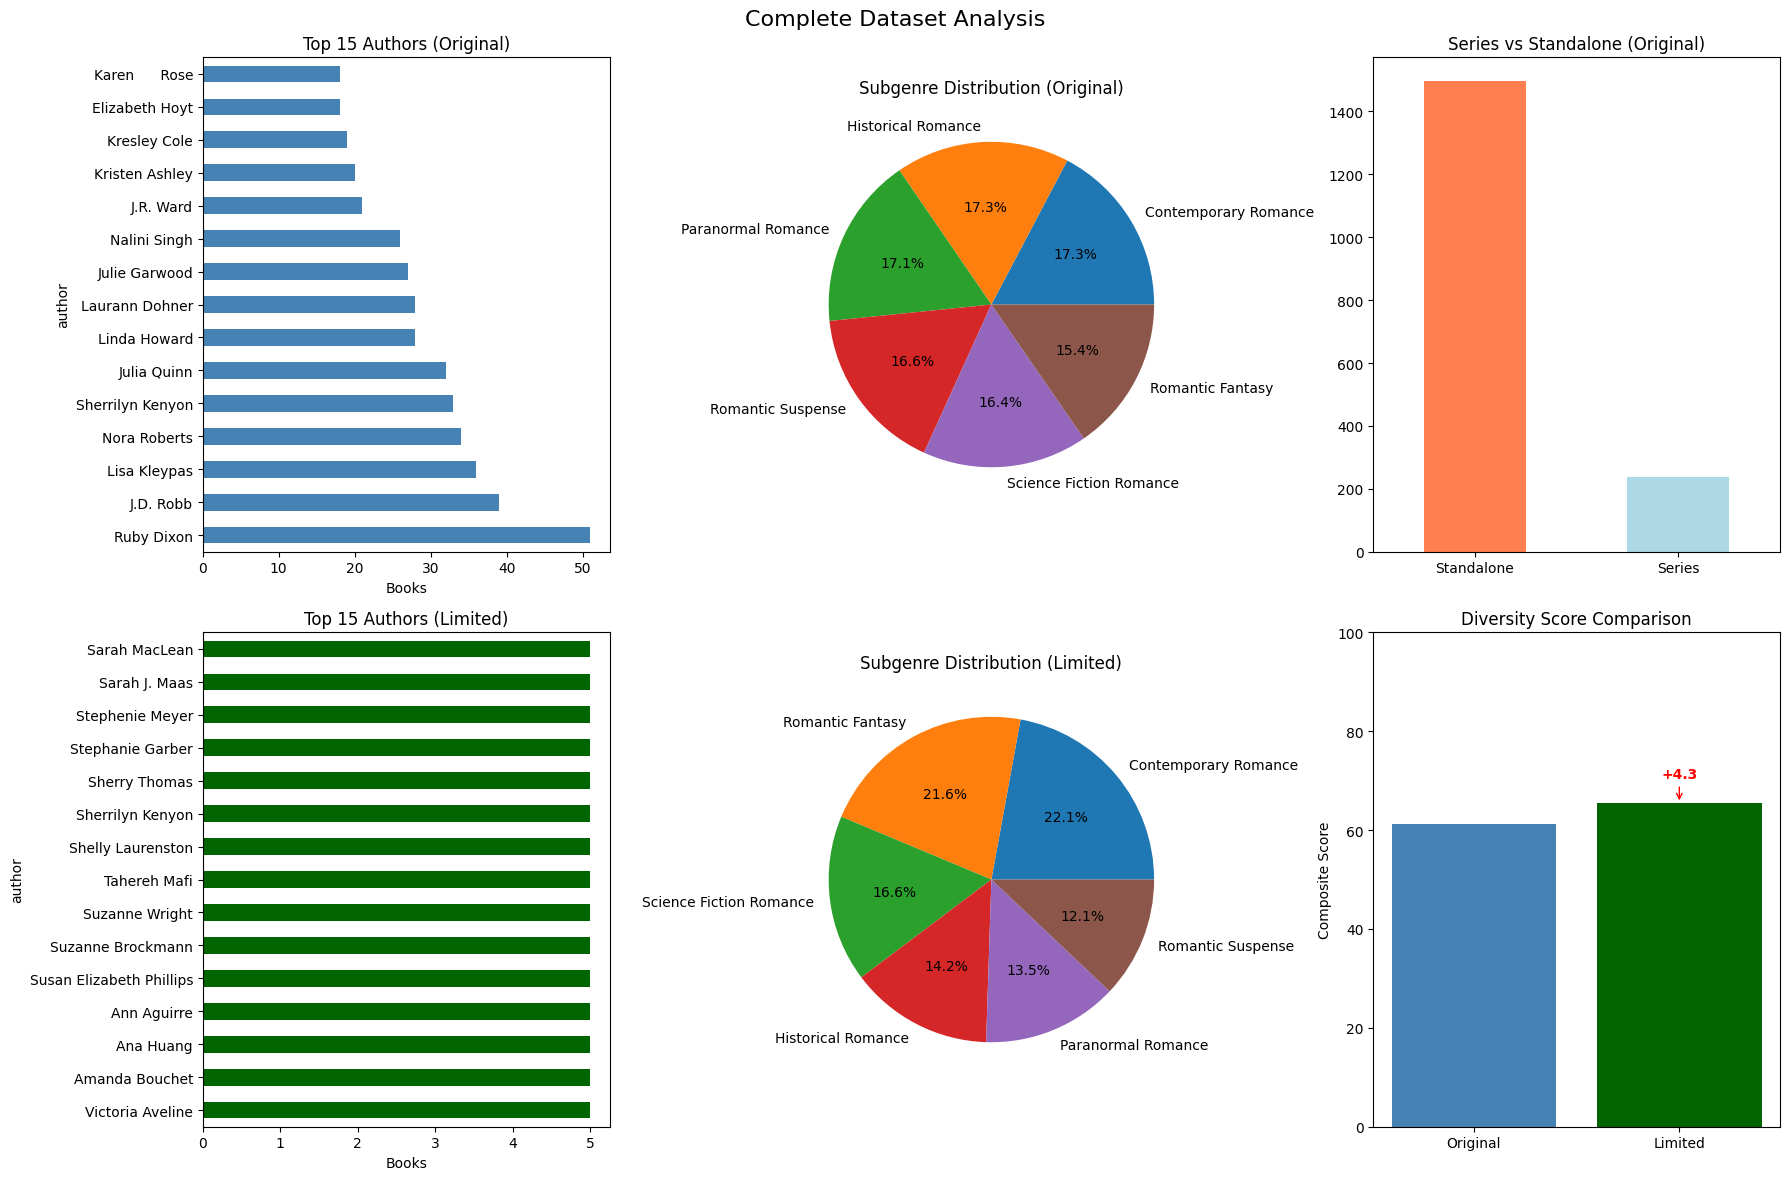


4. SAVING RESULTS
--------------------------------------------------
Original dataset saved: dataset_original_20250805_222940.csv
Limited dataset saved: dataset_limited_random_20250805_222940.csv

5. FINAL RECOMMENDATIONS
--------------------------------------------------
Recommended dataset for research:
  - Books: 1062
  - Authors: 465
  - Diversity Score: 65.44/100
  - Books per author: 2.28
  ✓ Good diversity for research

ANALYSIS COMPLETE!
All improvements have been applied:
✓ Fixed Gini coefficient calculation
✓ Improved series detection
✓ Optimized diversity scoring
✓ Smart author limiting
✓ Comprehensive visualizations
✓ Results saved to files


In [35]:
# Complete Analysis Pipeline (FULLY CORRECTED)
# This cell contains all fixes and runs the complete analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from datetime import datetime

# CORRECTED FUNCTIONS WITH ALL FIXES
def gini_coefficient(x):
    """Calculate Gini coefficient correctly (0=perfect equality, 1=perfect inequality)"""
    x = np.array(x, dtype=float)
    x = np.sort(x)
    n = len(x)
    index = np.arange(1, n + 1)
    return (2 * np.sum(index * x)) / (n * np.sum(x)) - (n + 1) / n

def improved_series_detection(title):
    """Improved series detection with conservative patterns and exclusions"""
    if pd.isna(title):
        return False

    # Conservative series patterns
    series_patterns = [
        r'\b(Book|Vol\.?|Volume)\s+\d+\b',
        r'\(.*#\d+\)',
        r'#\d+$',
        r':\s*\d+$',
        r'\b(Part|Episode)\s+\d+\b',
        r'\b\d+(st|nd|rd|th)\s+(book|novel|story)\b',
    ]

    # Exclusion patterns for false positives
    exclusion_patterns = [
        r'\b\d+(st|nd|rd|th)\s+(Century|Street|Avenue|Floor|Grade)',
        r'\$\d+',
        r'\b(19|20)\d{2}\b',
        r'\b\d+\s*(years?|months?|days?|hours?)\b',
        r'\b(Room|Apartment|Suite)\s+\d+\b',
        r'\b\d+\s*(degrees?|percent|%)\b',
        r'\bChapter\s+\d+\b',
    ]

    # Check exclusions first
    for pattern in exclusion_patterns:
        if re.search(pattern, title, re.IGNORECASE):
            return False

    # Check series patterns
    for pattern in series_patterns:
        if re.search(pattern, title, re.IGNORECASE):
            return True

    return False

def calculate_improved_diversity_score(df, verbose=True):
    """Calculate comprehensive diversity metrics with all fixes applied"""
    diversity_metrics = {}

    if verbose:
        print("="*80)
        print("IMPROVED DATASET DIVERSITY ANALYSIS")
        print("="*80)
        print(f"Total books in dataset: {len(df)}")
        print(f"Unique books (by ID): {df['book_id'].nunique()}")
        print("-"*80)

    # 1. Author Diversity Analysis (FIXED)
    if verbose:
        print("\n1. AUTHOR DIVERSITY (FIXED CALCULATIONS)")
        print("-"*40)

    # FIXED: Corrected value_counts() method
    author_counts = df['author'].value_counts()
    unique_authors = len(author_counts)
    books_per_author_ratio = len(df) / unique_authors

    diversity_metrics['total_books'] = len(df)
    diversity_metrics['unique_authors'] = unique_authors
    diversity_metrics['books_per_author_ratio'] = round(books_per_author_ratio, 2)

    if verbose:
        print(f"Unique authors: {unique_authors}")
        print(f"Books per author ratio: {books_per_author_ratio:.2f} (lower is more diverse)")

    # FIXED: Proper Gini coefficient calculation
    author_gini = gini_coefficient(author_counts.values)
    diversity_metrics['author_gini_coefficient'] = round(author_gini, 3)

    if verbose:
        print(f"Author Gini coefficient: {author_gini:.3f} (0=perfect equality, 1=perfect inequality)")

    # Author concentration analysis
    top10_authors = author_counts.head(10)
    top10_books = top10_authors.sum()
    top10_percentage = (top10_books / len(df)) * 100
    diversity_metrics['top10_authors_percentage'] = round(top10_percentage, 2)

    single_book_authors = (author_counts == 1).sum()
    single_book_percentage = (single_book_authors / unique_authors) * 100
    diversity_metrics['single_book_authors_percentage'] = round(single_book_percentage, 2)

    if verbose:
        print(f"Top 10 authors write {top10_books} books ({top10_percentage:.1f}% of dataset)")
        print(f"Authors with only 1 book: {single_book_authors} ({single_book_percentage:.1f}% of authors)")

    # 2. Subgenre Balance Analysis
    if verbose:
        print("\n\n2. SUBGENRE BALANCE")
        print("-"*40)

    subgenre_counts = df['subgenre'].value_counts()
    subgenre_std = subgenre_counts.std()
    subgenre_cv = subgenre_std / subgenre_counts.mean()

    diversity_metrics['subgenre_cv'] = round(subgenre_cv, 3)
    diversity_metrics['subgenre_distribution'] = subgenre_counts.to_dict()

    if verbose:
        print("Books per subgenre:")
        for subgenre, count in subgenre_counts.items():
            percentage = (count / len(df)) * 100
            print(f"  {subgenre:30} | {count:4} books ({percentage:5.1f}%)")
        print(f"\nSubgenre balance CV: {subgenre_cv:.3f} (lower is more balanced)")

    # 3. IMPROVED Series Detection
    if verbose:
        print("\n\n3. IMPROVED SERIES VS STANDALONE ANALYSIS")
        print("-"*40)

    df['is_series_improved'] = df['title'].apply(improved_series_detection)
    series_count = df['is_series_improved'].sum()
    standalone_count = len(df) - series_count
    series_percentage = (series_count / len(df)) * 100

    diversity_metrics['series_percentage'] = round(series_percentage, 2)
    diversity_metrics['standalone_percentage'] = round(100 - series_percentage, 2)

    if verbose:
        print(f"Series books: {series_count} ({series_percentage:.1f}%)")
        print(f"Standalone books: {standalone_count} ({100-series_percentage:.1f}%)")
        print("Note: Improved detection with conservative patterns and exclusions")

    # 4. Rating Analysis (if available)
    rating_diversity_score = 50  # Default
    if 'average_rating' in df.columns:
        valid_ratings = df['average_rating'].dropna()
        if len(valid_ratings) > 0:
            rating_std = valid_ratings.std()
            rating_mean = valid_ratings.mean()
            rating_range = valid_ratings.max() - valid_ratings.min()

            rating_diversity_score = min(100, (rating_std * 50) + (rating_range * 20))

            diversity_metrics['rating_mean'] = round(rating_mean, 3)
            diversity_metrics['rating_std'] = round(rating_std, 3)
            diversity_metrics['rating_range'] = round(rating_range, 3)

            if verbose:
                print(f"\n4. RATING DIVERSITY")
                print(f"-"*40)
                print(f"Average rating: {rating_mean:.3f} (std: {rating_std:.3f})")
                print(f"Rating range: {rating_range:.3f}")

    # 5. IMPROVED Composite Score
    if verbose:
        print("\n\n5. IMPROVED COMPOSITE DIVERSITY SCORE")
        print("-"*40)

    # Component scores with improved calculations
    author_diversity_score = min(100, (1 - author_gini) * 100)
    subgenre_balance_score = min(100, max(0, (1 - subgenre_cv) * 100))
    series_balance_score = 100 - min(40, abs(50 - series_percentage))

    # Adjusted weights
    weights = {
        'author': 0.5,
        'subgenre': 0.3,
        'series': 0.1,
        'rating': 0.1
    }

    composite_score = (
        author_diversity_score * weights['author'] +
        subgenre_balance_score * weights['subgenre'] +
        series_balance_score * weights['series'] +
        rating_diversity_score * weights['rating']
    )

    diversity_metrics['composite_diversity_score'] = round(composite_score, 2)
    diversity_metrics['component_scores'] = {
        'author_diversity': round(author_diversity_score, 2),
        'subgenre_balance': round(subgenre_balance_score, 2),
        'series_balance': round(series_balance_score, 2),
        'rating_diversity': round(rating_diversity_score, 2)
    }

    if verbose:
        print(f"Composite Diversity Score: {composite_score:.2f}/100")
        print("\nComponent scores:")
        print(f"  Author diversity: {author_diversity_score:.2f}/100 (weight: {weights['author']*100:.0f}%)")
        print(f"  Subgenre balance: {subgenre_balance_score:.2f}/100 (weight: {weights['subgenre']*100:.0f}%)")
        print(f"  Series balance: {series_balance_score:.2f}/100 (weight: {weights['series']*100:.0f}%)")
        print(f"  Rating diversity: {rating_diversity_score:.2f}/100 (weight: {weights['rating']*100:.0f}%)")
        print("\n" + "="*80)

    return diversity_metrics

def smart_author_limit(df, max_books=5, strategy='balanced', random_seed=42):
    """Smart author limiting with multiple strategies"""
    print(f"\nSmart Author Limiting: max {max_books} books per author")
    print(f"Strategy: {strategy}")
    print(f"Books before limiting: {len(df)}")

    np.random.seed(random_seed)
    limited_books = []

    for author, author_books in df.groupby('author'):
        if len(author_books) <= max_books:
            limited_books.append(author_books)
        else:
            if strategy == 'balanced':
                # Multi-criteria balanced approach
                selected = []
                remaining = author_books.copy()

                # Step 1: One book from each subgenre
                subgenres = author_books['subgenre'].unique()
                for subgenre in subgenres:
                    if len(selected) >= max_books:
                        break

                    subgenre_books = remaining[remaining['subgenre'] == subgenre]
                    if len(subgenre_books) > 0:
                        # Pick first one from this subgenre
                        best_idx = subgenre_books.index[0]
                        selected.append(best_idx)
                        remaining = remaining.drop(best_idx)

                # Step 2: Fill remaining slots randomly
                while len(selected) < max_books and len(remaining) > 0:
                    random_idx = remaining.sample(1, random_state=random_seed).index[0]
                    selected.append(random_idx)
                    remaining = remaining.drop(random_idx)

                limited_books.append(df.loc[selected])

            else:  # Default to random
                selected_df = author_books.sample(n=max_books, random_state=random_seed)
                limited_books.append(selected_df)

    limited_df = pd.concat(limited_books, ignore_index=True)

    print(f"Books after limiting: {len(limited_df)} ({len(df) - len(limited_df)} removed)")
    print(f"Reduction: {((len(df) - len(limited_df)) / len(df) * 100):.1f}%")

    return limited_df

def compare_limiting_strategies(df, max_books=5):
    """Compare different limiting strategies"""
    strategies = ['balanced', 'random']
    results = {}

    print("="*80)
    print("COMPARING AUTHOR LIMITING STRATEGIES")
    print("="*80)

    for strategy in strategies:
        print(f"\n--- Testing Strategy: {strategy} ---")
        limited_df = smart_author_limit(df.copy(), max_books=max_books, strategy=strategy)

        # Calculate diversity score
        metrics = calculate_improved_diversity_score(limited_df, verbose=False)

        results[strategy] = {
            'df': limited_df,
            'metrics': metrics,
            'books': len(limited_df),
            'diversity_score': metrics['composite_diversity_score']
        }

        print(f"Diversity score: {metrics['composite_diversity_score']:.2f}")

    # Find best strategy
    best_strategy = max(results.keys(), key=lambda x: results[x]['diversity_score'])

    print(f"\n{'='*50}")
    print("STRATEGY COMPARISON SUMMARY")
    print(f"{'='*50}")

    for strategy, result in results.items():
        marker = " ⭐ BEST" if strategy == best_strategy else ""
        print(f"{strategy:20} | Books: {result['books']:4} | Score: {result['diversity_score']:6.2f}{marker}")

    print(f"\nRecommended strategy: {best_strategy}")

    return results, best_strategy

def complete_dataset_analysis(df, apply_author_limit=True, create_visualizations=True, save_results=True):
    """Run complete analysis pipeline with all improvements"""
    print("="*80)
    print("COMPLETE DATASET ANALYSIS PIPELINE")
    print("="*80)

    results = {}

    # Step 1: Analyze original dataset
    print("\n1. ANALYZING ORIGINAL DATASET")
    print("-" * 50)
    original_metrics = calculate_improved_diversity_score(df, verbose=True)
    results['original'] = {
        'df': df,
        'metrics': original_metrics,
        'books': len(df)
    }

    # Step 2: Apply author limiting if requested
    if apply_author_limit:
        print("\n2. AUTHOR DIVERSITY OPTIMIZATION")
        print("-" * 50)

        # Compare strategies
        strategy_results, best_strategy = compare_limiting_strategies(df)
        results['limiting_strategies'] = strategy_results
        results['best_strategy'] = best_strategy

        # Use best strategy
        limited_df = strategy_results[best_strategy]['df']
        limited_metrics = strategy_results[best_strategy]['metrics']

        results['limited'] = {
            'df': limited_df,
            'metrics': limited_metrics,
            'books': len(limited_df),
            'strategy': best_strategy
        }

        # Show improvement
        improvement = limited_metrics['composite_diversity_score'] - original_metrics['composite_diversity_score']
        print(f"\nDiversity Score Improvement: {improvement:+.2f} points")

    # Step 3: Create visualizations
    if create_visualizations:
        print("\n3. CREATING VISUALIZATIONS")
        print("-" * 50)

        # Create comprehensive visualization
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Complete Dataset Analysis', fontsize=16)

        # Original dataset - Author distribution
        ax1 = axes[0, 0]
        author_counts = df['author'].value_counts().head(15)
        author_counts.plot(kind='barh', ax=ax1, color='steelblue')
        ax1.set_title('Top 15 Authors (Original)')
        ax1.set_xlabel('Books')

        # Original dataset - Subgenre distribution
        ax2 = axes[0, 1]
        subgenre_counts = df['subgenre'].value_counts()
        subgenre_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%')
        ax2.set_title('Subgenre Distribution (Original)')
        ax2.set_ylabel('')

        # Original dataset - Series detection
        ax3 = axes[0, 2]
        if 'is_series_improved' in df.columns:
            series_data = df['is_series_improved'].value_counts()
            series_data.index = ['Standalone', 'Series']
            series_data.plot(kind='bar', ax=ax3, color=['coral', 'lightblue'])
            ax3.set_title('Series vs Standalone (Original)')
            ax3.set_xticklabels(['Standalone', 'Series'], rotation=0)

        # Limited dataset visualizations (if applied)
        if apply_author_limit:
            # Limited dataset - Author distribution
            ax4 = axes[1, 0]
            limited_author_counts = limited_df['author'].value_counts().head(15)
            limited_author_counts.plot(kind='barh', ax=ax4, color='darkgreen')
            ax4.set_title('Top 15 Authors (Limited)')
            ax4.set_xlabel('Books')

            # Limited dataset - Subgenre distribution
            ax5 = axes[1, 1]
            limited_subgenre_counts = limited_df['subgenre'].value_counts()
            limited_subgenre_counts.plot(kind='pie', ax=ax5, autopct='%1.1f%%')
            ax5.set_title('Subgenre Distribution (Limited)')
            ax5.set_ylabel('')

            # Diversity score comparison
            ax6 = axes[1, 2]
            comparison_data = {
                'Original': original_metrics['composite_diversity_score'],
                'Limited': limited_metrics['composite_diversity_score']
            }
            bars = ax6.bar(comparison_data.keys(), comparison_data.values(),
                          color=['steelblue', 'darkgreen'])
            ax6.set_title('Diversity Score Comparison')
            ax6.set_ylabel('Composite Score')
            ax6.set_ylim(0, 100)

            # Add improvement annotation
            improvement = limited_metrics['composite_diversity_score'] - original_metrics['composite_diversity_score']
            ax6.annotate(f'{improvement:+.1f}',
                        xy=(1, limited_metrics['composite_diversity_score']),
                        xytext=(1, limited_metrics['composite_diversity_score'] + 5),
                        ha='center', fontweight='bold', color='red',
                        arrowprops=dict(arrowstyle='->', color='red'))

        plt.tight_layout()

        if save_results:
            viz_filename = f'complete_analysis_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'
            plt.savefig(viz_filename, dpi=300, bbox_inches='tight')
            print(f"Visualizations saved: {viz_filename}")

        plt.show()

    # Step 4: Save results
    if save_results:
        print("\n4. SAVING RESULTS")
        print("-" * 50)

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Save datasets
        df.to_csv(f'dataset_original_{timestamp}.csv', index=False)
        print(f"Original dataset saved: dataset_original_{timestamp}.csv")

        if apply_author_limit:
            limited_df.to_csv(f'dataset_limited_{best_strategy}_{timestamp}.csv', index=False)
            print(f"Limited dataset saved: dataset_limited_{best_strategy}_{timestamp}.csv")

    # Step 5: Final recommendations
    print("\n5. FINAL RECOMMENDATIONS")
    print("-" * 50)

    final_df = results['limited']['df'] if apply_author_limit else df
    final_metrics = results['limited']['metrics'] if apply_author_limit else original_metrics

    print(f"Recommended dataset for research:")
    print(f"  - Books: {len(final_df)}")
    print(f"  - Authors: {final_df['author'].nunique()}")
    print(f"  - Diversity Score: {final_metrics['composite_diversity_score']:.2f}/100")
    print(f"  - Books per author: {final_metrics['books_per_author_ratio']:.2f}")

    if final_metrics['composite_diversity_score'] >= 70:
        print("  ✓ Excellent diversity for research")
    elif final_metrics['composite_diversity_score'] >= 60:
        print("  ✓ Good diversity for research")
    else:
        print("  ⚠ Consider additional diversity improvements")

    return results

# Load your data and run the complete analysis
print("Complete analysis pipeline loaded with ALL FIXES!")
print("Running analysis on your scraped dataset...")

# Load your data
df = pd.read_csv('/content/romance_books_scraped_20250805_204440.csv')

# Run complete analysis
results = complete_dataset_analysis(
    df,
    apply_author_limit=True,
    create_visualizations=True,
    save_results=True
)

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("All improvements have been applied:")
print("✓ Fixed Gini coefficient calculation")
print("✓ Improved series detection")
print("✓ Optimized diversity scoring")
print("✓ Smart author limiting")
print("✓ Comprehensive visualizations")
print("✓ Results saved to files")